In [1]:
import pandas as pd

In [160]:
import os
import pandas as pd

# Define the base path for the "lending" folder
base_path = "health"#"lending" #"health"#

# List all directories (runs) in the "lending" folder
runs = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]

# Create a dictionary to store the results
results = {}

# Iterate through each run and load the files
for run in runs:
    final_file_path = os.path.join(base_path, run, "final_ranked_decision_metrics.csv")
    cv_file_path = os.path.join(base_path, run, "cv_ranked_decision_metrics.csv")
    
    # Dynamically generate variable names
    results[f"results_{run}"] = pd.read_csv(final_file_path)
    results[f"results_cv_{run}"] = pd.read_csv(cv_file_path)

# Access the dataframes dynamically
for key, df in results.items():
    print(f"{key}: Loaded dataframe with shape {df.shape}")


results_787_base_111: Loaded dataframe with shape (10, 31)
results_cv_787_base_111: Loaded dataframe with shape (10, 31)
results_787_base_1111: Loaded dataframe with shape (10, 31)
results_cv_787_base_1111: Loaded dataframe with shape (10, 31)
results_787_base_42: Loaded dataframe with shape (10, 31)
results_cv_787_base_42: Loaded dataframe with shape (10, 31)


In [147]:
comparison_dict = {}

# Iterate through the dynamically loaded results
for run, result_file in results.items():
    if "cv" not in run:  # Only process the "final_ranked_decision_metrics" files
        # Get the corresponding "cv_ranked_decision_metrics" file
        result_cv_run = f"results_cv_{run.split('_', 1)[1]}"  # Match the cv version
        result_cv_file = results.get(result_cv_run)
        
        if result_cv_file is None:
            print(f"Missing corresponding cv file for run: {run}")
            continue
        
        # Extract the sample size and strategy type (e.g., "3000" and "base" from "results_3000_3_base_111")
        run_parts = run.split('_')
        sample_size = run_parts[1]
        strategy_type = run_parts[3]  # "base", "strict", or "strictest"
        
        # Process each column excluding the first one
        for col in result_file.columns[1:]:
            if col not in comparison_dict:
                comparison_dict[col] = {}
            
            # Iterate over rows (index is the first column "Actor/Criterion")
            for index, row in result_file.iterrows():
                actor = row["Actor/Criterion"]
                
                # Initialize nested structure with sample size and strategy type keys if not present
                if actor not in comparison_dict[col]:
                    comparison_dict[col][actor] = {}
                if sample_size not in comparison_dict[col][actor]:
                    comparison_dict[col][actor][sample_size] = {}
                if strategy_type not in comparison_dict[col][actor][sample_size]:
                    comparison_dict[col][actor][sample_size][strategy_type] = {"results": [], "results_cv": []}
                
                # Append values to the lists
                comparison_dict[col][actor][sample_size][strategy_type]["results"].append(row[col])
                comparison_dict[col][actor][sample_size][strategy_type]["results_cv"].append(result_cv_file.loc[index, col])


In [161]:
comparison_dict = {}

# Iterate through the dynamically loaded results
for run, result_file in results.items():
    if "cv" not in run:  # Only process the "final_ranked_decision_metrics" files
        # Get the corresponding "cv_ranked_decision_metrics" file
        result_cv_run = f"results_cv_{run.split('_', 1)[1]}"  # Match the cv version
        result_cv_file = results.get(result_cv_run)
        
        if result_cv_file is None:
            print(f"Missing corresponding cv file for run: {run}")
            continue
        
        # Extract the sample size (e.g., "3000" from "results_3000_3_base_111")
        run_parts = run.split('_')
        sample_size = run_parts[1]
        
        # Process each column excluding the first one
        for col in result_file.columns[1:]:
            if col not in comparison_dict:
                comparison_dict[col] = {}
            
            # Iterate over rows (index is the first column "Actor/Criterion")
            for index, row in result_file.iterrows():
                actor = row["Actor/Criterion"]
                
                # Initialize nested structure with sample size key if not present
                if actor not in comparison_dict[col]:
                    comparison_dict[col][actor] = {}
                if sample_size not in comparison_dict[col][actor]:
                    comparison_dict[col][actor][sample_size] = {"results": [], "results_cv": []}
                
                # Append values to the lists
                comparison_dict[col][actor][sample_size]["results"].append(row[col])
                comparison_dict[col][actor][sample_size]["results_cv"].append(result_cv_file.loc[index, col])


In [162]:
comparison_dict 

{'Total_cognitive_score': {'Outcome_Maxim': {'787': {'results': [977.9,
     977.9,
     977.9],
    'results_cv': [3876.1, 3876.1, 3876.1]}},
  'Kalai-Smorodinsky': {'787': {'results': [977.4, 977.4, 977.4],
    'results_cv': [3876.1, 3876.1, 3876.1]}},
  'Policy_Maker': {'787': {'results': [972.6000000476838,
     972.6000000476838,
     972.6000000476838],
    'results_cv': [3869.1, 3869.1, 3871.6]}},
  'Compromise Programming': {'787': {'results': [957.500000047684,
     955.7000000953676,
     961.3000000476836],
    'results_cv': [3796.499999809265, 3807.199999856949, 3790.799999856949]}},
  'Nash Bargaining': {'787': {'results': [922.0999998569488,
     911.8999999046324,
     911.8999999046324],
    'results_cv': [3511.800000119209,
     3523.7999999523163,
     3514.3000000953675]}},
  'Parent': {'787': {'results': [924.0999998569488,
     916.6999998569488,
     916.6999998569488],
    'results_cv': [3511.800000119209,
     3486.0000000476834,
     3514.3000000953675]}},
  'N

In [150]:
import numpy as np

def compute_avg_and_std_abs_pw_diff_with_strategy(data_dict):
    """
    Compute the average and standard deviation of absolute pairwise differences
    between 'results' and 'results_cv' for each outer key, sample size, and strategy type,
    averaged over all actors.

    Parameters:
        data_dict (dict): The input dictionary with structure:
                          {outer_key: {actor: {sample_size: {strategy_type: {"results": [...], "results_cv": [...]}}}}}

    Returns:
        dict: A dictionary with structure:
              {outer_key: {sample_size: {strategy_type: {"mean": avg_absolute_difference, "std": std_absolute_difference}}}}
    """
    result = {}

    for outer_key, actors_data in data_dict.items():
        result[outer_key] = {}  # Initialize dictionary for each outer key
        
        # Gather data by sample size and strategy type
        sample_strategy_diff = {}
        for actor, sample_sizes in actors_data.items():
            for sample_size, strategies in sample_sizes.items():
                for strategy_type, values in strategies.items():
                    # Compute pairwise absolute differences
                    results = values["results"]
                    results_cv = values["results_cv"]
                    abs_differences = [abs(r - r_cv) for r, r_cv in zip(results, results_cv)]
                    
                    # Accumulate differences by sample size and strategy type
                    if (sample_size, strategy_type) not in sample_strategy_diff:
                        sample_strategy_diff[(sample_size, strategy_type)] = []
                    sample_strategy_diff[(sample_size, strategy_type)].extend(abs_differences)
        
        # Compute the average and standard deviation for each sample size and strategy type
        for (sample_size, strategy_type), diffs in sample_strategy_diff.items():
            mean_diff = np.mean(diffs) if diffs else 0
            std_diff = np.std(diffs) if diffs else 0
            
            # Initialize nested structure if not present
            if sample_size not in result[outer_key]:
                result[outer_key][sample_size] = {}
            result[outer_key][sample_size][strategy_type] = {"mean": mean_diff, "std": std_diff}

    return result

mean_dict=compute_avg_and_std_abs_pw_diff_with_strategy(comparison_dict)
mean_dict

TypeError: list indices must be integers or slices, not str

In [ ]:
def plot_metrics_scatter_filtered(data_dict, selected_metrics, sample_sizes_to_include):
    """
    Create a scatter plot with metrics on the vertical axis and mean values 
    for specific sample sizes on the horizontal axis.

    Parameters:
        data_dict (dict): Dictionary with metrics as keys, each containing sample sizes and strategies with their stats.
        selected_metrics (list): List of metrics to include in the plot.
        sample_sizes_to_include (list): List of sample sizes to include in the plot.
    """
    # Filter sample sizes
    sample_sizes = [size for size in sample_sizes_to_include if size in {key for metric in data_dict.values() for key in metric.keys()}]
    
    sample_size_colors = {
        "1000": "blue",
        "10000": "purple"
    }

    # Prepare data for plotting
    y_positions = np.arange(len(selected_metrics))  # Metrics on the vertical axis
    
    # Create plot
    fig, ax = plt.subplots(figsize=(8, 4))
    
    for i, metric in enumerate(selected_metrics):
        for sample_size in sample_sizes:
            if sample_size in data_dict[metric] and "base" in data_dict[metric][sample_size]:
                mean = data_dict[metric][sample_size]["base"]["mean"]
                std = data_dict[metric][sample_size]["base"]["std"]
                color = sample_size_colors.get(sample_size, "gray")
                
                # Scatter plot
                ax.scatter(mean, y_positions[i], color=color, label=f"Sample Size {sample_size}" if i == 0 else None)
                
                # Error bar
                ax.errorbar(mean, y_positions[i], xerr=std, fmt='o', color=color, alpha=0.7, capsize=4)
    
    # Customize the plot
    ax.set_yticks(y_positions)
    ax.set_yticklabels(selected_metrics)  # Metrics as labels on the vertical axis
    ax.set_xlabel("Mean Values (with Std Dev)")
    ax.grid(axis='x', linestyle='--', alpha=0.7)

    # Add a legend
    handles = [
        plt.Line2D([], [], color=color, marker='o', linestyle='None', label=f"{size} samples")
        for size, color in sample_size_colors.items() if size in sample_sizes
    ]
    ax.legend(handles=handles, ncol=2, bbox_to_anchor=(0.5, 1.15) , loc='upper center')
    
    plt.tight_layout(rect=[0, 0.1, 1, 1])  # Leave space for legend
    plt.show()

# Example usage
sample_sizes_to_include = ["1000", "10000"]
selected_metrics = ['Accuracy', 'Precision', 'Recall', 'Demographic_Parity', 'Equal_Opportunity', 'Conditional_Outcome_Parity', 'Total_Profit', 'Total_Loss', 'Unexploited_Profit']

plot_metrics_scatter_filtered(mean_dict, selected_metrics, sample_sizes_to_include)


In [ ]:
comparison_dict = {}

# Iterate through the dynamically loaded results
for run, result_file in results.items():
    if "cv" not in run and "knn" not in run:  # Exclude "cv" and "knn" files
        # Get the corresponding "cv_ranked_decision_metrics" file
        result_cv_run = f"results_cv_{run.split('_', 1)[1]}"  # Match the cv version
        result_cv_file = results.get(result_cv_run)
        
        if result_cv_file is None:
            print(f"Missing corresponding cv file for run: {run}")
            continue
        
        # Extract the sample size and strategy type (e.g., "3000" and "base" from "results_3000_3_base_111")
        run_parts = run.split('_')
        sample_size = run_parts[1]
        strategy_type = run_parts[3]  # "base", "strict", or "strictest"
        
        # Process each column excluding the first one
        for col in result_file.columns[1:]:
            if col not in comparison_dict:
                comparison_dict[col] = {}
            
            # Iterate over rows (index is the first column "Actor/Criterion")
            for index, row in result_file.iterrows():
                actor = row["Actor/Criterion"]
                
                # Initialize nested structure with sample size and strategy type keys if not present
                if actor not in comparison_dict[col]:
                    comparison_dict[col][actor] = {}
                if sample_size not in comparison_dict[col][actor]:
                    comparison_dict[col][actor][sample_size] = {}
                if strategy_type not in comparison_dict[col][actor][sample_size]:
                    comparison_dict[col][actor][sample_size][strategy_type] = {"results": [], "results_cv": []}
                
                # Append values to the lists
                comparison_dict[col][actor][sample_size][strategy_type]["results"].append(row[col])
                comparison_dict[col][actor][sample_size][strategy_type]["results_cv"].append(result_cv_file.loc[index, col])


In [156]:
comparison_dict = {}

# Iterate through the dynamically loaded results
for run, result_file in results.items():
    if "cv" not in run and "knn" not in run:  # Exclude "cv" and "knn" files
        # Get the corresponding "cv_ranked_decision_metrics" file
        result_cv_run = f"results_cv_{run.split('_', 1)[1]}"  # Match the cv version
        result_cv_file = results.get(result_cv_run)
        
        if result_cv_file is None:
            print(f"Missing corresponding cv file for run: {run}")
            continue
        
        # Extract the sample size and strategy type (e.g., "3000" and "base" from "results_3000_3_base_111")
        run_parts = run.split('_')
        sample_size = run_parts[1]
        strategy_type = run_parts[3]  # "base", "strict", or "strictest"
        
        # Process each column excluding the first one
        for col in result_file.columns[1:]:
            if col not in comparison_dict:
                comparison_dict[col] = {}
            
            # Iterate over rows (index is the first column "Actor/Criterion")
            for index, row in result_file.iterrows():
                actor = row["Actor/Criterion"]
                
                # Initialize nested structure with sample size and strategy type keys if not present
                if actor not in comparison_dict[col]:
                    comparison_dict[col][actor] = {}
                if sample_size not in comparison_dict[col][actor]:
                    comparison_dict[col][actor][sample_size] = {}
                if strategy_type not in comparison_dict[col][actor][sample_size]:
                    comparison_dict[col][actor][sample_size][strategy_type] = {"results": [], "results_cv": []}
                
                # Append values to the lists
                comparison_dict[col][actor][sample_size][strategy_type]["results"].append(row[col])
                comparison_dict[col][actor][sample_size][strategy_type]["results_cv"].append(result_cv_file.loc[index, col])


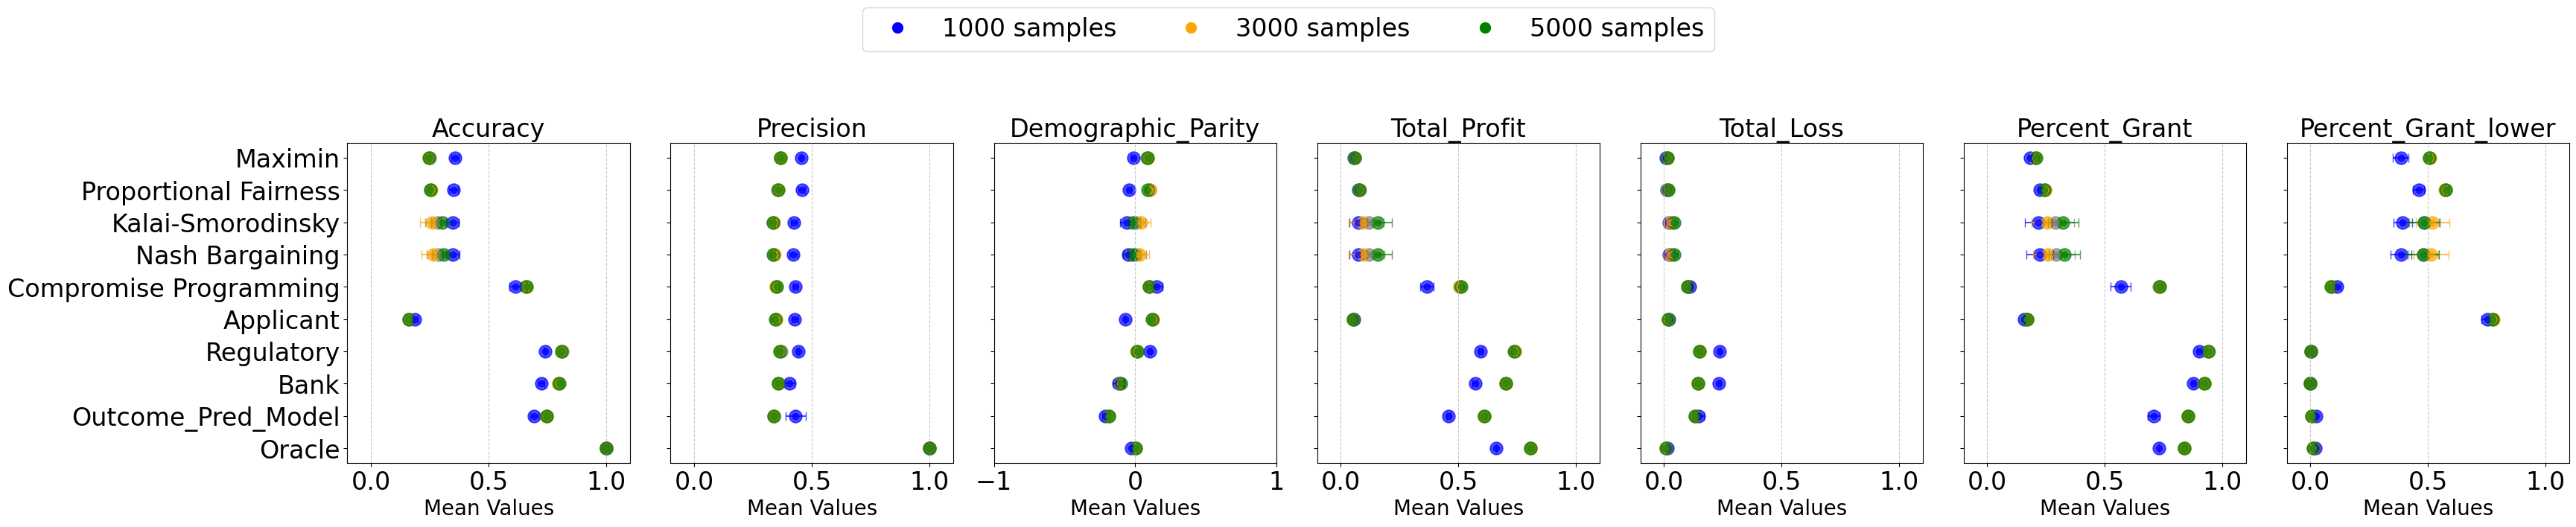

In [158]:
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.stats import sem

import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import sem
plt.rc('font', size=20)  # Default text size
plt.rc('axes', titlesize=24)  # Font size for plot titles
plt.rc('axes', labelsize=20)  # Font size for x and y labels
plt.rc('xtick', labelsize=24)  # Font size for x-axis tick labels
plt.rc('ytick', labelsize=24)  # Font size for y-axis tick labels
plt.rc('legend', fontsize=24)  # Font size for legend
plt.rc('figure', titlesize=18)  # Font size for figure title

def add_jitter(y_values, jitter_amount=0.1):
    """
    Add random jitter to y-values to avoid overlap in visualization.
    
    Parameters:
        y_values: list
            Original y-values.
        jitter_amount: float
            Maximum jitter to add to each y-value.
    
    Returns:
        list: Jittered y-values.
    """
    return [y + np.random.uniform(-jitter_amount, jitter_amount) for y in y_values]


def visualize_selected_metrics_horizontal_rows(data_dict, selected_metrics, y_order, sample_size_colors):
    """
    Visualizes the mean values of distributions in the dictionary for selected outer keys using scatter plots,
    with actors/criteria on the vertical axis and metric values on the horizontal axis,
    including confidence intervals for the results.
    
    Parameters:
        data_dict: dict
            Nested dictionary with the structure:
            {outer_key: {inner_key: {sample_size: {strategy_type: {"results": [values]}}}}}
        selected_metrics: list
            List of outer keys (metrics) to visualize.
        y_order: list
            Custom Y-axis order for the actors/criteria.
        sample_size_colors: dict
            Dictionary mapping sample sizes to colors.
    """
    #metrics_per_row = 3
    #num_metrics = len(selected_metrics)
    #num_rows = math.ceil(num_metrics / metrics_per_row)

    #fig, axes = plt.subplots(num_rows, metrics_per_row, figsize=(9 * metrics_per_row, 1 * num_rows), sharey=True)
    num_metrics = len(selected_metrics)
    num_rows = 1  # Force all metrics to be in one row

    fig, axes = plt.subplots(num_rows, num_metrics, figsize=(5 * num_metrics, 6), sharey=True)
    axes = axes.flatten()  # Flatten to make indexing simpler

    for i, outer_key in enumerate(selected_metrics):
        ax = axes[i]
        if outer_key in data_dict:
            # Prepare data for scatter plot
            for actor in y_order:
                if actor in data_dict[outer_key]:
                    for sample_size, strategies in data_dict[outer_key][actor].items():
                        if "base" in strategies:  # Filter for "base" strategy only
                            values = strategies["base"]
                            color = sample_size_colors.get(sample_size, "gray")  # Default color if sample size not mapped
                            
                            # Calculate the mean and confidence interval
                            mean_results = np.mean(values["results"])
                            ci_results = sem(values["results"]) * 1.96  # 95% confidence interval
                            
                            
                            # Scatter plot for mean "results"
                            ax.scatter(
                                mean_results,  # X-axis: mean value of results
                                actor,  # Y-axis: actor
                                alpha=0.7,
                                marker='o',
                                color=color,
                                s=150,  # Size of the point
                                label=f'{sample_size} Results' if actor == y_order[0] else None  # Add label once
                            )
                            
                            # Add confidence interval as an error bar
                            ax.errorbar(
                                mean_results,  # X-axis: mean value
                                actor,  # Y-axis: actor
                                xerr=ci_results,  # Add error bar based on confidence interval
                                fmt='o',  # Dot marker for mean
                                color=color,
                                alpha=0.7,
                                capsize=4  # Add caps to error bars
                            )

            # Set custom x-axis range
            if outer_key in ['Demographic_Parity', 'Equal_Opportunity', 'Conditional_Outcome_Parity']:
                ax.set_xlim(-1, 1)
            elif outer_key in ['Precision', 'Recall', 'Accuracy', 'Percent_Grant', 'Percent_Grant_lower', 'Percent_Not_Grant',
                               "Total_Profit", "Total_Loss", "Unexploited_Profit"]:
                ax.set_xlim(-0.1, 1.1)
            else:
                pass

            # Add labels and title
            ax.set_xlabel("Mean Values")
            ax.set_title(f"{outer_key}")
            ax.grid(axis='x', linestyle='--', alpha=0.7)

    # Remove unused subplots
    for j in range(num_metrics, len(axes)):
        fig.delaxes(axes[j])

    # Set shared y-axis labels
    axes[0].set_yticks(range(len(y_order)))
    axes[0].set_yticklabels(y_order)

    # Add a single legend
    handles = [
        plt.Line2D([], [], color=color, marker='o',markersize=10, linestyle='None', label=f'{size} samples')
        for size, color in sample_size_colors.items()
    ]
    fig.legend(handles=handles, loc='lower center', ncol=4, bbox_to_anchor=(0.5, 1.07))

    plt.tight_layout()
    plt.show()

# Example usage
sample_size_colors = {
    "1000": "blue",
    "3000": "orange",
    "5000": "green",
   # "10000": "purple"
}
selected_metrics = ['Accuracy',  'Precision','Demographic_Parity',
                    'Total_Profit', 'Total_Loss',  'Percent_Grant', 'Percent_Grant_lower']
y_order= ['Oracle', 'Outcome_Pred_Model', 'Bank','Regulatory', 'Applicant', 'Compromise Programming', 'Nash Bargaining', 'Kalai-Smorodinsky', 'Proportional Fairness', 'Maximin']
visualize_selected_metrics_horizontal_rows(comparison_dict, selected_metrics, y_order, sample_size_colors)

#'Unexploited_Profit', 'Equal_Opportunity', 

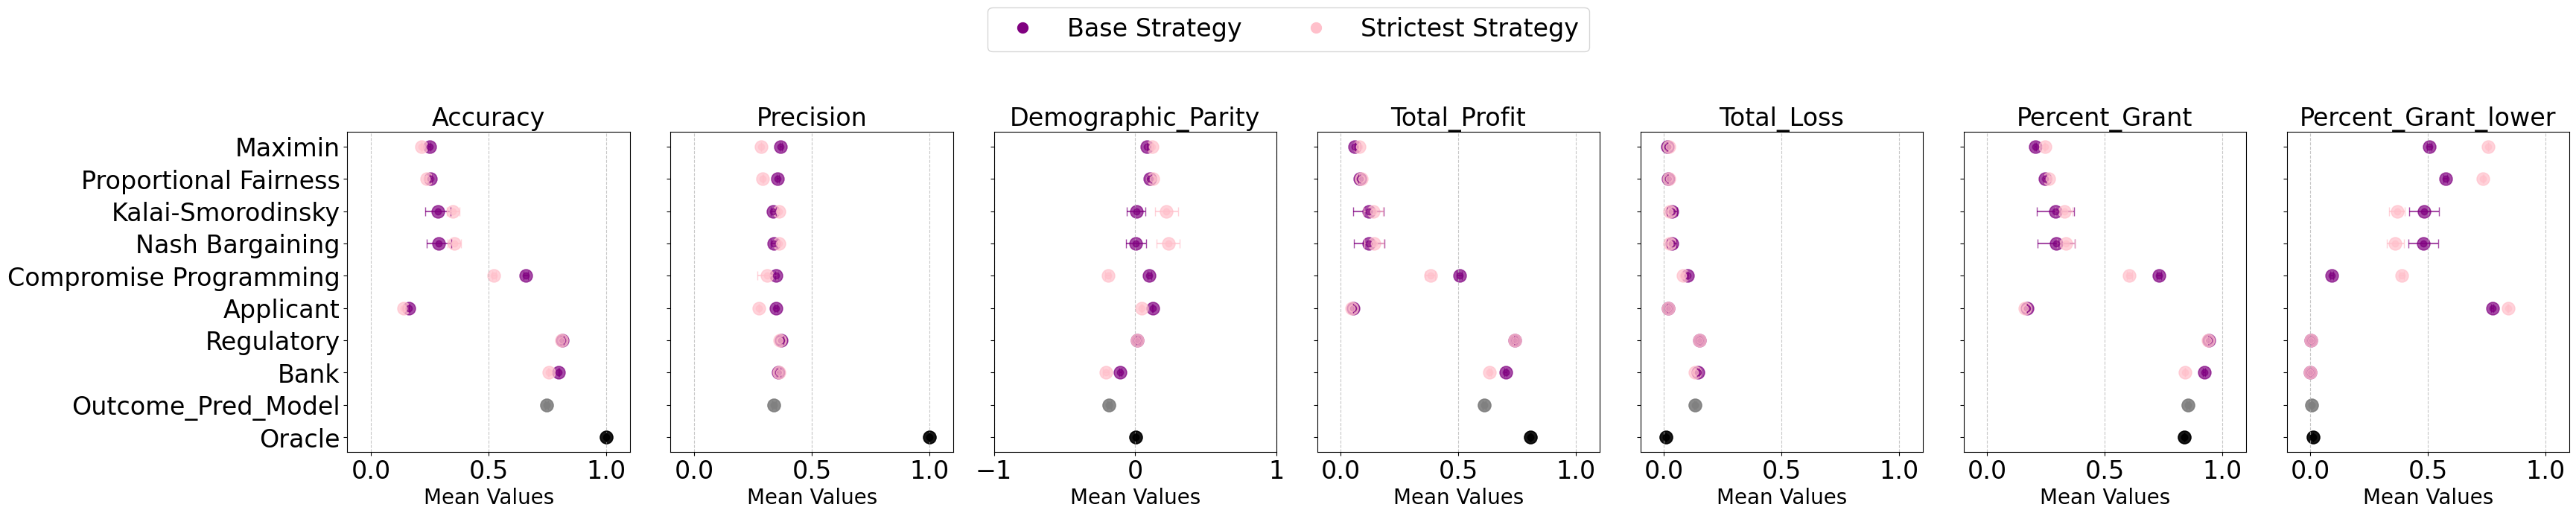

In [159]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import sem
plt.rc('font', size=20)  # Default text size
plt.rc('axes', titlesize=24)  # Font size for plot titles
plt.rc('axes', labelsize=20)  # Font size for x and y labels
plt.rc('xtick', labelsize=24)  # Font size for x-axis tick labels
plt.rc('ytick', labelsize=24)  # Font size for y-axis tick labels
plt.rc('legend', fontsize=24)  # Font size for legend
plt.rc('figure', titlesize=18)  # Font size for figure title
def visualize_strategy_comparison(data_dict, selected_metrics, y_order, strategies=["base", "strictest"]): #"mild"
    """
    Visualizes the mean values of distributions in the dictionary for selected outer keys using scatter plots,
    comparing different strategies for the same sample size.

    Parameters:
        data_dict: dict
            Nested dictionary with the structure:
            {outer_key: {inner_key: {sample_size: {strategy_type: {"results": [values]}}}}}
        selected_metrics: list
            List of outer keys (metrics) to visualize.
        y_order: list
            Custom Y-axis order for the actors/criteria.
        strategies: list
            List of strategies to compare (e.g., ["base", "strict", "strictest"]).
    """
    sample_size = "10000"  # Fixed sample size for comparison
    strategy_colors = {"base": "purple","strictest": "pink"}  # Colors for strategies "mild": "red"
    actor_colors = {"Oracle": "black", "Outcome_Pred_Model": "gray"}  # Specific color for Oracle, others will use strategy colors

    #metrics_per_row = 3
    #num_metrics = len(selected_metrics)
    #num_rows = math.ceil(num_metrics / metrics_per_row)

    #fig, axes = plt.subplots(num_rows, metrics_per_row, figsize=(4 * metrics_per_row, 4 * num_rows), sharey=True)
    num_metrics = len(selected_metrics)
    num_rows = 1  # Force all metrics to be in one row

    fig, axes = plt.subplots(num_rows, num_metrics, figsize=(5 * num_metrics, 6), sharey=True)
    axes = axes.flatten()  # Flatten to make indexing simpler

    for i, outer_key in enumerate(selected_metrics):
        ax = axes[i]
        if outer_key in data_dict:
            # Prepare data for scatter plot
            for actor in y_order:
                if actor in data_dict[outer_key] and sample_size in data_dict[outer_key][actor]:
                    for strategy in strategies:
                        if strategy in data_dict[outer_key][actor][sample_size]:
                            values = data_dict[outer_key][actor][sample_size][strategy]
                            color = actor_colors.get(actor, strategy_colors.get(strategy, "gray"))

                            # Calculate the mean and confidence interval
                            mean_results = np.mean(values["results"])
                            ci_results = sem(values["results"]) * 1.96  # 95% confidence interval

                            # Scatter plot for mean "results"
                            ax.scatter(
                                mean_results,  # X-axis: mean value of results
                                actor,  # Y-axis: actor
                                alpha=0.7,
                                marker='o',
                                color=color,
                                s=150,  # Size of the point
                                label=f'{strategy.capitalize()} Strategy' if actor == y_order[0] else None  # Add label once
                            )

                            # Add confidence interval as an error bar
                            ax.errorbar(
                                mean_results,  # X-axis: mean value
                                actor,  # Y-axis: actor
                                xerr=ci_results,  # Add error bar based on confidence interval
                                fmt='o',  # Dot marker for mean
                                color=color,
                                alpha=0.7,
                                capsize=4  # Add caps to error bars
                            )

            # Set custom x-axis range
            if outer_key in ['Demographic_Parity', 'Equal_Opportunity', 'Conditional_Outcome_Parity']:
                ax.set_xlim(-1, 1)
            elif outer_key in ['Precision', 'Recall', 'Accuracy', 'Percent_Grant', 'Percent_Grant_lower', 'Percent_Not_Grant',
                               "Total_Profit", "Total_Loss", "Unexploited_Profit"]:
                ax.set_xlim(-0.1, 1.1)
            else:
                pass

            # Add labels and title
            ax.set_xlabel("Mean Values")
            ax.set_title(f"{outer_key}")
            ax.grid(axis='x', linestyle='--', alpha=0.7)

    # Remove unused subplots
    for j in range(num_metrics, len(axes)):
        fig.delaxes(axes[j])

    # Set shared y-axis labels
    axes[0].set_yticks(range(len(y_order)))
    axes[0].set_yticklabels(y_order)

    # Add a single legend
    handles = [
        plt.Line2D([], [], color=color, marker='o', linestyle='None', markersize=10, label=f'{strategy.capitalize()} Strategy')
        for strategy, color in strategy_colors.items()
    ] 
    fig.legend(handles=handles, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.2))

    plt.tight_layout()
    plt.show()
# Example usage
selected_metrics = ['Accuracy',  'Precision','Demographic_Parity',
                    'Total_Profit', 'Total_Loss',  'Percent_Grant', 'Percent_Grant_lower']
y_order= ['Oracle', 'Outcome_Pred_Model', 'Bank','Regulatory', 'Applicant', 'Compromise Programming', 'Nash Bargaining', 'Kalai-Smorodinsky', 'Proportional Fairness', 'Maximin']
visualize_strategy_comparison(comparison_dict, selected_metrics, y_order)


In [151]:
comparison_dict = {}

# Iterate through the dynamically loaded results
for run, result_file in results.items():
    if "cv" not in run:  # Only process non-CV files
        # Get the corresponding CV file
        result_cv_run = f"results_cv_{run.split('_', 1)[1]}"  # Match the CV version
        result_cv_file = results.get(result_cv_run)
        
        if result_cv_file is None:
            print(f"Missing corresponding CV file for run: {run}")
            continue
        
        # Extract parts of the filename for sample size and model type
        run_parts = run.split('_')
        sample_size = run_parts[1]
        strategy_type = run_parts[3]  # "base" or others
        
        # Filter for "base" strategy only
        if strategy_type != "base":
            continue
        
        model_type = "knn" if "knn" in run else "rf"  # "knn" or "rf" (default)
        
        # Process each column excluding the first one
        for col in result_file.columns[1:]:
            if col not in comparison_dict:
                comparison_dict[col] = {}
            
            # Iterate over rows (index is the first column "Actor/Criterion")
            for index, row in result_file.iterrows():
                actor = row["Actor/Criterion"]
                
                # Initialize nested structure with sample size and model type
                if actor not in comparison_dict[col]:
                    comparison_dict[col][actor] = {}
                if sample_size not in comparison_dict[col][actor]:
                    comparison_dict[col][actor][sample_size] = {}
                if model_type not in comparison_dict[col][actor][sample_size]:
                    comparison_dict[col][actor][sample_size][model_type] = {"results": [], "results_cv": []}
                
                # Append values to the lists
                comparison_dict[col][actor][sample_size][model_type]["results"].append(row[col])
                comparison_dict[col][actor][sample_size][model_type]["results_cv"].append(result_cv_file.loc[index, col])


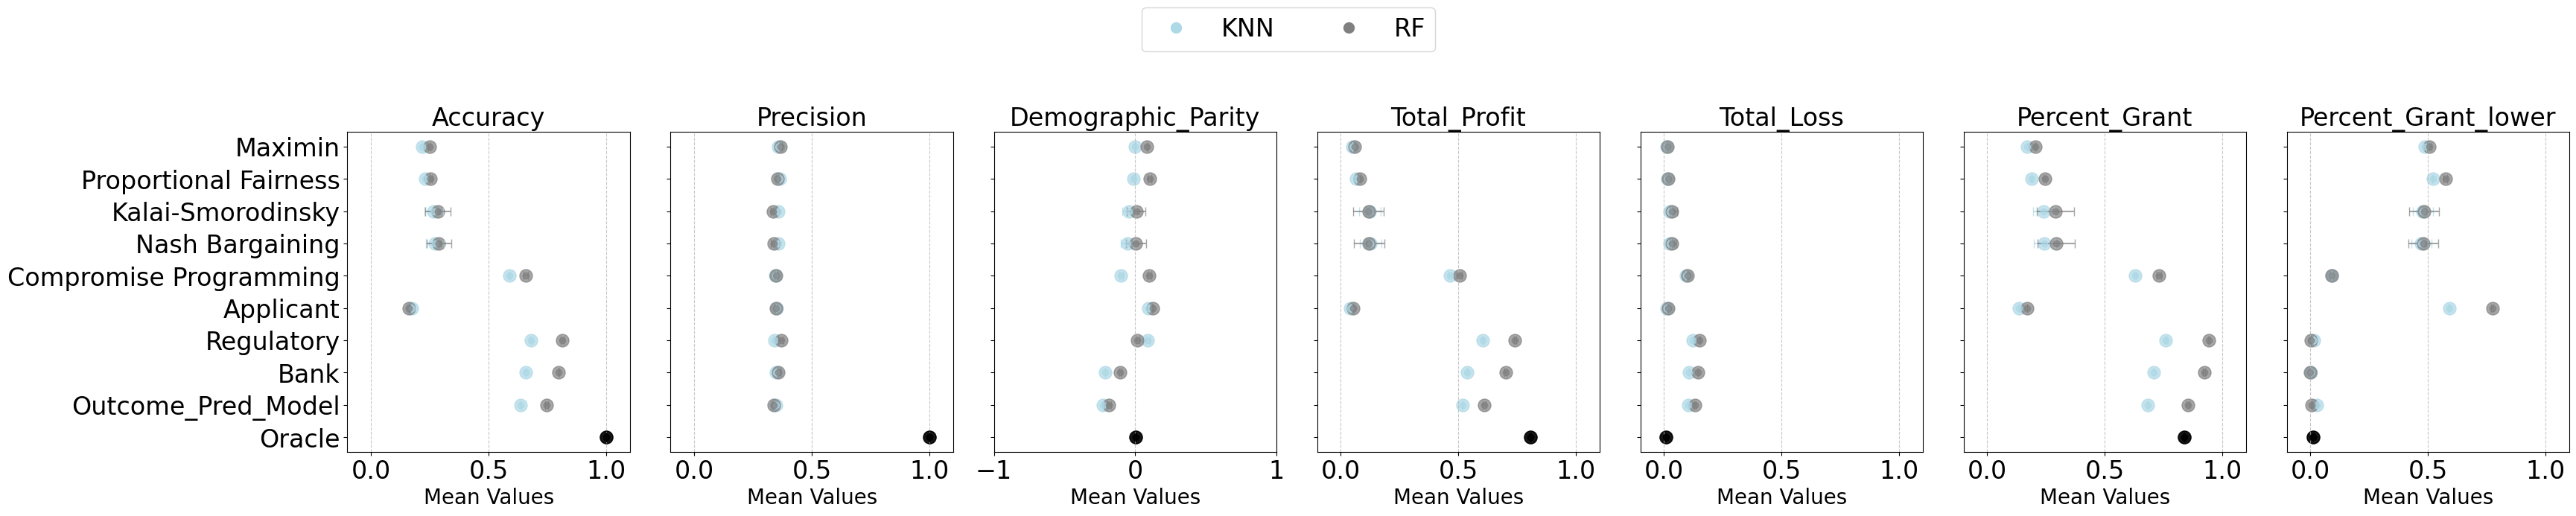

In [153]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import sem
plt.rc('font', size=20)  # Default text size
plt.rc('axes', titlesize=24)  # Font size for plot titles
plt.rc('axes', labelsize=20)  # Font size for x and y labels
plt.rc('xtick', labelsize=24)  # Font size for x-axis tick labels
plt.rc('ytick', labelsize=24)  # Font size for y-axis tick labels
plt.rc('legend', fontsize=24)  # Font size for legend
plt.rc('figure', titlesize=18)  # Font size for figure title
def visualize_model_comparison(data_dict, selected_metrics, y_order):
    """
    Visualizes the mean values of distributions in the dictionary for selected metrics using scatter plots,
    comparing KNN and RF for the same sample size.

    Parameters:
        data_dict: dict
            Nested dictionary with the structure:
            {outer_key: {inner_key: {sample_size: {model_type: {"results": [values]}}}}}
        selected_metrics: list
            List of outer keys (metrics) to visualize.
        y_order: list
            Custom Y-axis order for the actors/criteria.
    """
    sample_size = "10000"  # Fixed sample size for comparison
    model_colors = {"knn": "lightblue", "rf": "gray"}  # Colors for KNN and RF
    actor_colors = {"Oracle": "black"}

    #metrics_per_row = 3
    #num_metrics = len(selected_metrics)
    #num_rows = math.ceil(num_metrics / metrics_per_row)

    #fig, axes = plt.subplots(num_rows, metrics_per_row, figsize=(1 * metrics_per_row, 0 * num_rows), sharey=True)
    num_metrics = len(selected_metrics)
    num_rows = 1  # Force all metrics to be in one row

    fig, axes = plt.subplots(num_rows, num_metrics, figsize=(5 * num_metrics, 6), sharey=True)
    axes = axes.flatten()  # Flatten to make indexing simpler

    for i, outer_key in enumerate(selected_metrics):
        ax = axes[i]
        if outer_key in data_dict:
            # Prepare data for scatter plot
            for actor in y_order:
                if actor in data_dict[outer_key] and sample_size in data_dict[outer_key][actor]:
                    for model_type in ["knn", "rf"]:
                        if model_type in data_dict[outer_key][actor][sample_size]:
                            values = data_dict[outer_key][actor][sample_size][model_type]
                            color = actor_colors.get(actor, model_colors.get(model_type, "gray"))

                            # Calculate the mean and confidence interval
                            mean_results = np.mean(values["results"])
                            ci_results = sem(values["results"]) * 1.96  # 95% confidence interval

                            # Scatter plot for mean "results"
                            ax.scatter(
                                mean_results,  # X-axis: mean value of results
                                actor,  # Y-axis: actor
                                alpha=0.7,
                                marker='o',
                                color=color,
                                s=150,  # Size of the point
                                label=f'{model_type.upper()}' if actor == y_order[0] else None  # Add label once
                            )

                            # Add confidence interval as an error bar
                            ax.errorbar(
                                mean_results,  # X-axis: mean value
                                actor,  # Y-axis: actor
                                xerr=ci_results,  # Add error bar based on confidence interval
                                fmt='o',  # Dot marker for mean
                                color=color,
                                alpha=0.7,
                                capsize=4  # Add caps to error bars
                            )

            # Set custom x-axis range
            if outer_key in ['Demographic_Parity', 'Equal_Opportunity', 'Conditional_Outcome_Parity']:
                ax.set_xlim(-1, 1)
            elif outer_key in ['Precision', 'Recall', 'Accuracy', 'Percent_Grant', 'Percent_Grant_lower', 'Percent_Not_Grant',
                               "Total_Profit", "Total_Loss", "Unexploited_Profit"]:
                ax.set_xlim(-0.1, 1.1)
            else:
                pass

            # Add labels and title
            ax.set_xlabel("Mean Values")
            ax.set_title(f"{outer_key}")
            ax.grid(axis='x', linestyle='--', alpha=0.7)

    # Remove unused subplots
    for j in range(num_metrics, len(axes)):
        fig.delaxes(axes[j])

    # Set shared y-axis labels
    axes[0].set_yticks(range(len(y_order)))
    axes[0].set_yticklabels(y_order)

    # Add a single legend
    handles = [
        plt.Line2D([], [], color=color, marker='o', markersize=10, linestyle='None', label=f'{model.upper()}')
        for model, color in model_colors.items()
    ]
    fig.legend(handles=handles, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.2))

    plt.tight_layout()
    plt.show()


# Example usage
selected_metrics = ['Accuracy',  'Precision','Demographic_Parity',
                    'Total_Profit', 'Total_Loss',  'Percent_Grant', 'Percent_Grant_lower']
y_order = ['Oracle', 'Outcome_Pred_Model', 'Bank', 'Regulatory', 'Applicant', 'Compromise Programming', 
           'Nash Bargaining', 'Kalai-Smorodinsky', 'Proportional Fairness', 'Maximin'] 
#,  , ,, 'Percent_Not_Grant' 'Recall','Conditional_Outcome_Parity'

visualize_model_comparison(comparison_dict, selected_metrics, y_order)


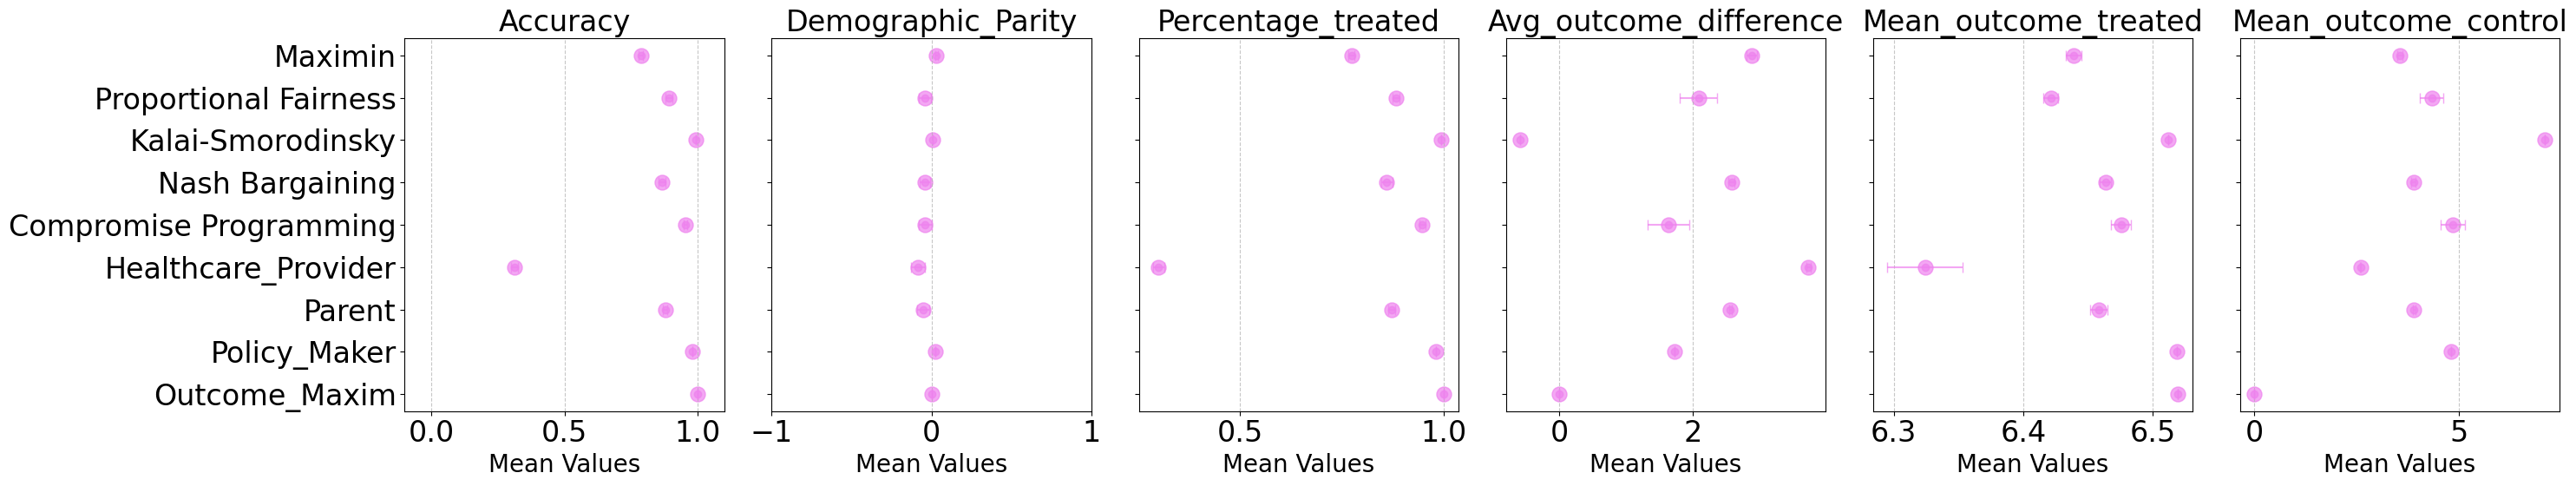

In [163]:
plt.rc('font', size=20)  # Default text size
plt.rc('axes', titlesize=24)  # Font size for plot titles
plt.rc('axes', labelsize=20)  # Font size for x and y labels
plt.rc('xtick', labelsize=24)  # Font size for x-axis tick labels
plt.rc('ytick', labelsize=24)  # Font size for y-axis tick labels
plt.rc('legend', fontsize=24)  # Font size for legend
plt.rc('figure', titlesize=18)  # Font size for figure title

def visualize_selected_metrics_horizontal_rows(data_dict, selected_metrics, y_order, sample_size_colors):
    """
    Visualizes the mean values of distributions in the dictionary for selected outer keys using scatter plots,
    with actors/criteria on the vertical axis and metric values on the horizontal axis,
    including confidence intervals for the results.
    """
    import numpy as np
    from scipy.stats import sem
    import matplotlib.pyplot as plt
    import math

    #metrics_per_row = 3
    #num_metrics = len(selected_metrics)
    #num_rows = math.ceil(num_metrics / metrics_per_row)
    num_metrics = len(selected_metrics)
    num_rows = 1  # Force all metrics to be in one row

    fig, axes = plt.subplots(num_rows, num_metrics, figsize=(5 * num_metrics, 6), sharey=True)

   # fig, axes = plt.subplots(num_rows, metrics_per_row, figsize=(4 * metrics_per_row, 4 * num_rows), sharey=True)
    axes = axes.flatten()  # Flatten to make indexing simpler

    for i, outer_key in enumerate(selected_metrics):
        ax = axes[i]
        if outer_key in data_dict:
            # Prepare data for scatter plot
            for actor in y_order:
                if actor in data_dict[outer_key]:
                    for sample_size, values in data_dict[outer_key][actor].items():
                        if "results" in values:  # Only process if results exist
                            color = sample_size_colors.get(sample_size, "violet")  # Default color if sample size not mapped
                            
                            # Calculate the mean and confidence interval
                            mean_results = np.mean(values["results"]) if values["results"] else None
                            ci_results = sem(values["results"]) * 1.96 if values["results"] else 0  # 95% confidence interval

                            # Skip plotting if mean_results is None
                            if mean_results is None:
                                continue

                            # Get the y-position of the actor
                            y_pos = y_order.index(actor)

                            # Scatter plot for mean "results"
                            ax.scatter(
                                mean_results,  # X-axis: mean value of results
                                y_pos,  # Y-axis: actor index
                                alpha=0.7,
                                marker='o',
                                color=color,
                                s=150,  # Size of the point
                                label=f'{sample_size} Results' if y_pos == 0 else None  # Add label once
                            )
                            
                            # Add confidence interval as an error bar
                            ax.errorbar(
                                mean_results,  # X-axis: mean value
                                y_pos,  # Y-axis: actor index
                                xerr=ci_results,  # Add error bar based on confidence interval
                                fmt='o',  # Dot marker for mean
                                color=color,
                                alpha=0.7,
                                capsize=4  # Add caps to error bars
                            )

            # Set custom x-axis range
            if outer_key in ['Demographic_Parity', 'Equal_Opportunity', 'Conditional_Outcome_Parity']:
                ax.set_xlim(-1, 1)
            elif outer_key in ['Precision', 'Recall', 'Accuracy', 'Percent_Grant', 'Percent_Grant_lower', 'Percent_Not_Grant',
                               "Total_Profit", "Total_Loss", "Unexploited_Profit"]:
                ax.set_xlim(-0.1, 1.1)

            # Add labels and title
            ax.set_xlabel("Mean Values")
            ax.set_title(f"{outer_key}")
            ax.grid(axis='x', linestyle='--', alpha=0.7)

    # Remove unused subplots
    for j in range(num_metrics, len(axes)):
        fig.delaxes(axes[j])

    # Set shared y-axis labels
    for ax in axes[:num_metrics]:
        ax.set_yticks(range(len(y_order)))
        ax.set_yticklabels(y_order)

    # Add a single legend
    handles = [
        plt.Line2D([], [], color=color, marker='o', markersize=10, linestyle='None', label=f'{size} samples')
        for size, color in sample_size_colors.items()
    ]
    #fig.legend(handles=handles, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.2))

    plt.tight_layout()
    plt.show()

selected_metrics = [ 'Accuracy', 'Demographic_Parity','Percentage_treated', 'Avg_outcome_difference','Mean_outcome_treated','Mean_outcome_control']
y_order = ['Outcome_Maxim', 'Policy_Maker', 'Parent', 'Healthcare_Provider', 'Compromise Programming', 
           'Nash Bargaining', 'Kalai-Smorodinsky', 'Proportional Fairness', 'Maximin']
sample_size_colors = {
        "747": "violet"
    }

visualize_selected_metrics_horizontal_rows(comparison_dict, selected_metrics, y_order, sample_size_colors)


In [248]:
comparison_dict['Accuracy']['Healthcare_Provider']

{'787': {'results': [0.32, 0.3, 0.32, 0.2933333333333333],
  'results_cv': [0.304857621440536,
   0.3015075376884422,
   0.3031825795644891,
   0.2680067001675041]}}

In [106]:
for metric in selected_metrics:
    if metric not in comparison_h_dict:
        print(f"Missing metric: {metric}")

In [95]:
comparison_h_dict['Avg_outcome_difference']

{'Policy_Maker': {'results': [1.7183673310442042,
   1.7183673310442042,
   1.7183673310442042,
   1.7183673310442042],
  'results_cv': [1.7183673310442042,
   1.7183673310442042,
   1.7183673310442042,
   1.7183673310442042]},
 'Compromise Programming': {'results': [1.5494505358266322,
   1.683451526046646,
   1.6783450585016064,
   1.5739436500509028],
  'results_cv': [1.5494505358266322,
   1.683451526046646,
   1.6783450585016064,
   1.5739436500509028]},
 'Nash Bargaining': {'results': [2.571538466306833,
   2.571538466306833,
   2.571538466306833,
   2.571538466306833],
  'results_cv': [2.571538466306833,
   2.571538466306833,
   2.571538466306833,
   2.571538466306833]},
 'Parent': {'results': [2.537373745321023,
   2.537373745321023,
   2.537373745321023,
   2.537373745321023],
  'results_cv': [2.537373745321023,
   2.537373745321023,
   2.537373745321023,
   2.537373745321023]},
 'Maximin': {'results': [2.8298368363391537,
   2.8884381401853187,
   2.8813894586437367,
   2.953

In [91]:
comparison_h_dict

{'Total_cognitive_score': {'Policy_Maker': {'results': [972.6000000476838,
    972.6000000476838,
    972.6000000476838,
    972.6000000476838],
   'results_cv': [972.6000000476838,
    972.6000000476838,
    972.6000000476838,
    972.6000000476838]},
  'Compromise Programming': {'results': [963.0000000953676,
    955.7000000953676,
    960.2000000953676,
    958.5000000953676],
   'results_cv': [963.0000000953676,
    955.7000000953676,
    960.2000000953676,
    958.5000000953676]},
  'Nash Bargaining': {'results': [919.2999999046324,
    919.2999999046324,
    919.2999999046324,
    919.2999999046324],
   'results_cv': [919.2999999046324,
    919.2999999046324,
    919.2999999046324,
    919.2999999046324]},
  'Parent': {'results': [924.0999998569488,
    924.0999998569488,
    924.0999998569488,
    924.0999998569488],
   'results_cv': [924.0999998569488,
    924.0999998569488,
    924.0999998569488,
    924.0999998569488]},
  'Maximin': {'results': [871.9999997854231,
    867.999

In [41]:
comparison_dict['Demographic_Parity Normalized']['Nash Social Welfare']

{'results': [0.5293023255813952,
  0.5251908396946564,
  0.4861902674265672,
  0.4323252354982652],
 'results_cv': [0.0296064729680031,
  0.0308909777456416,
  0.067442794058611,
  0.0826514232019107]}

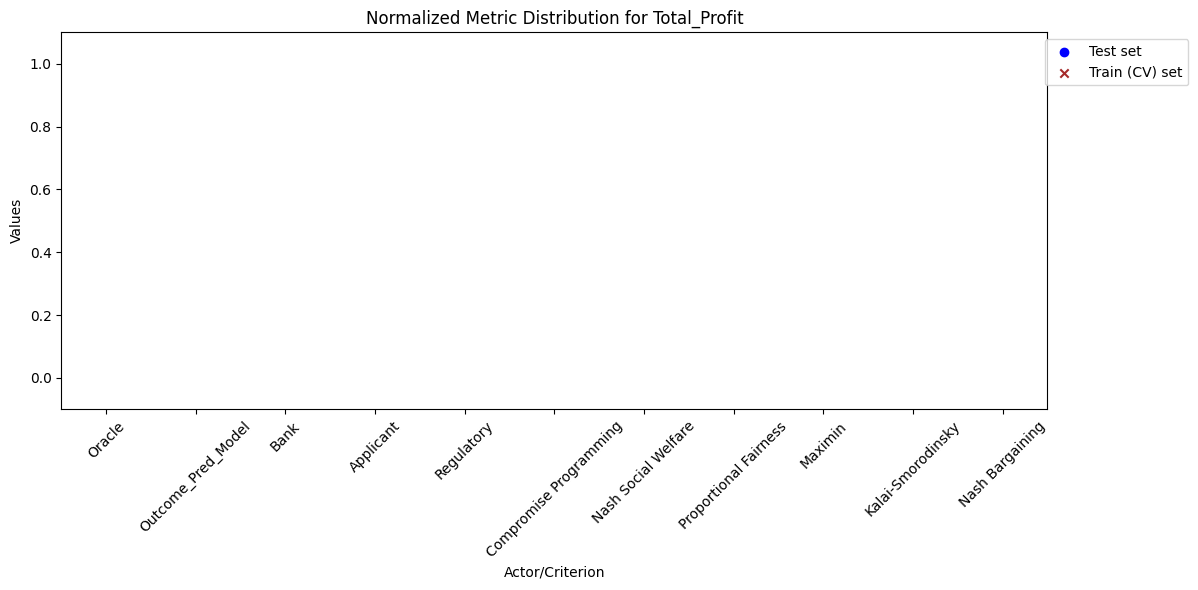

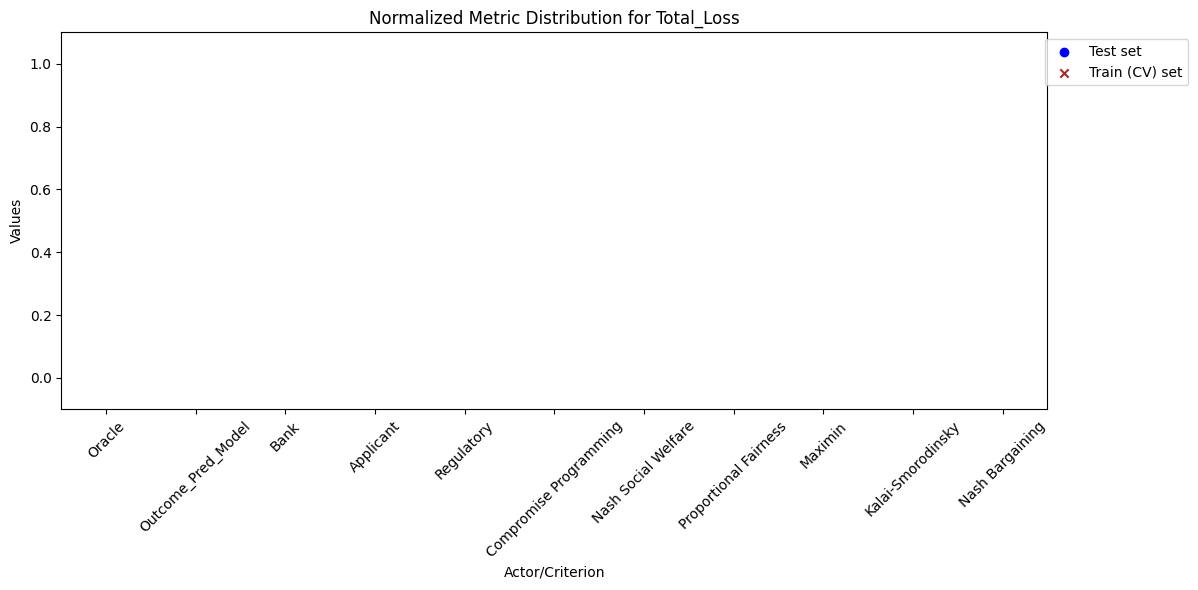

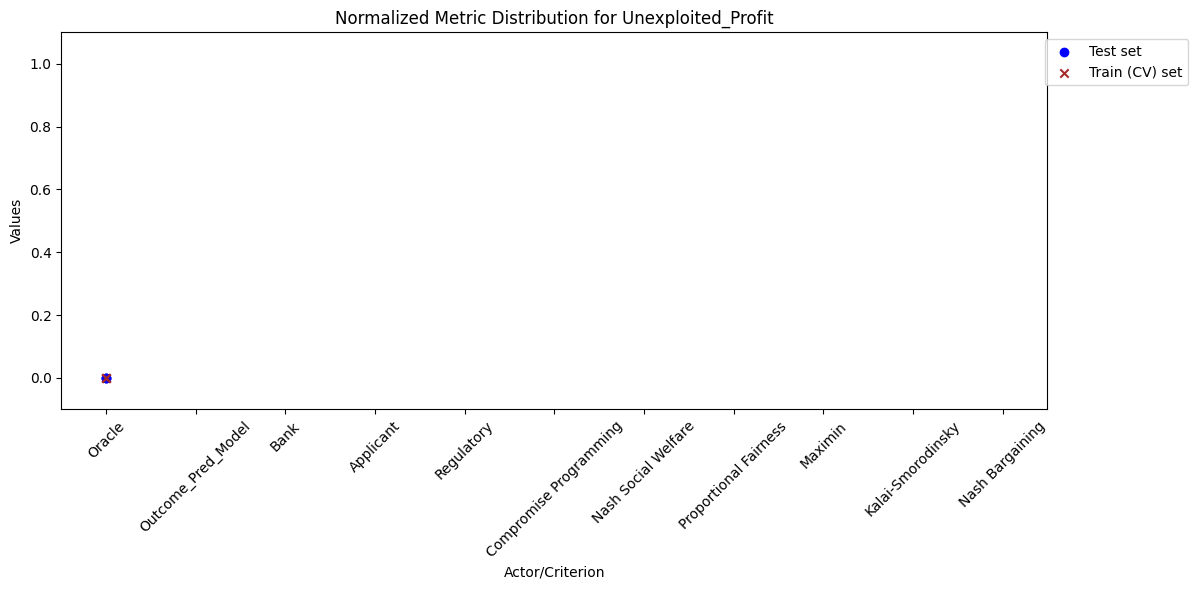

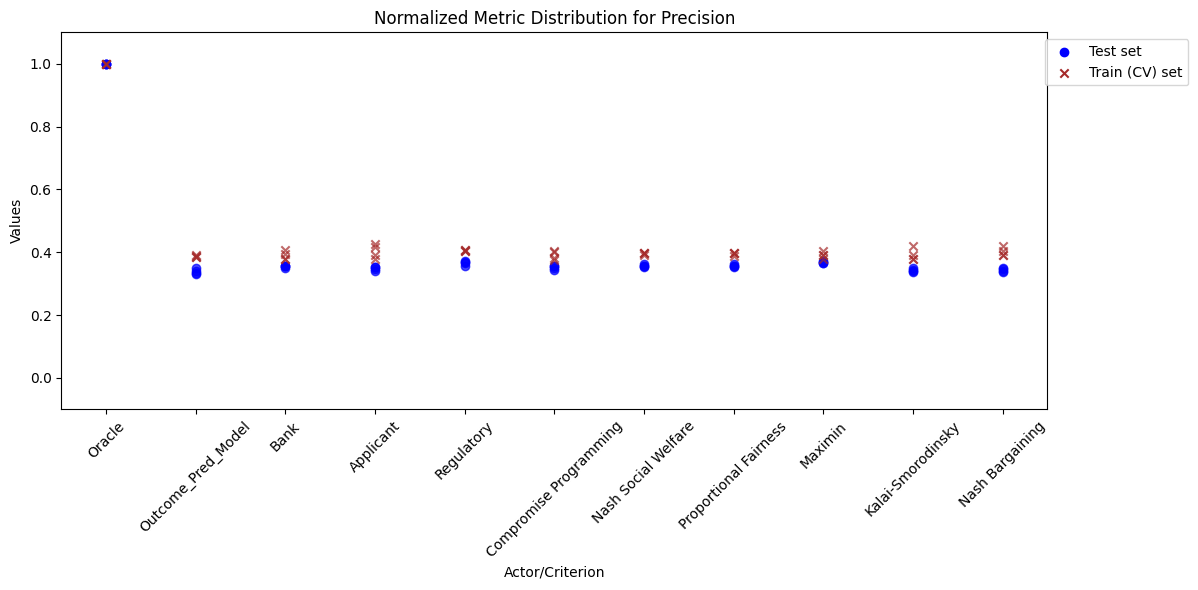

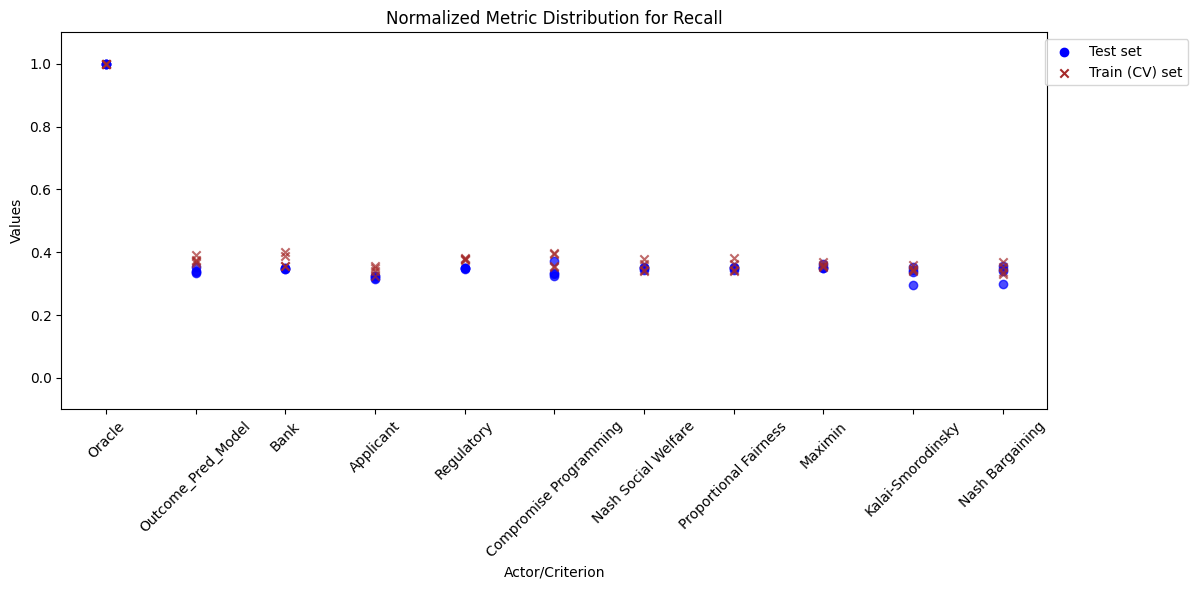

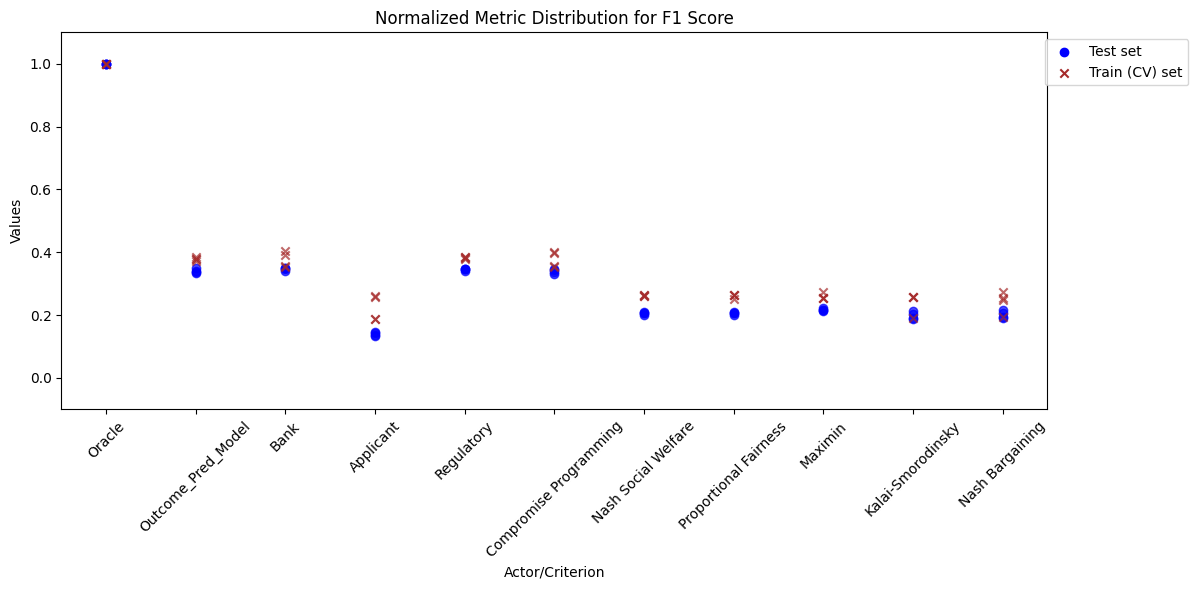

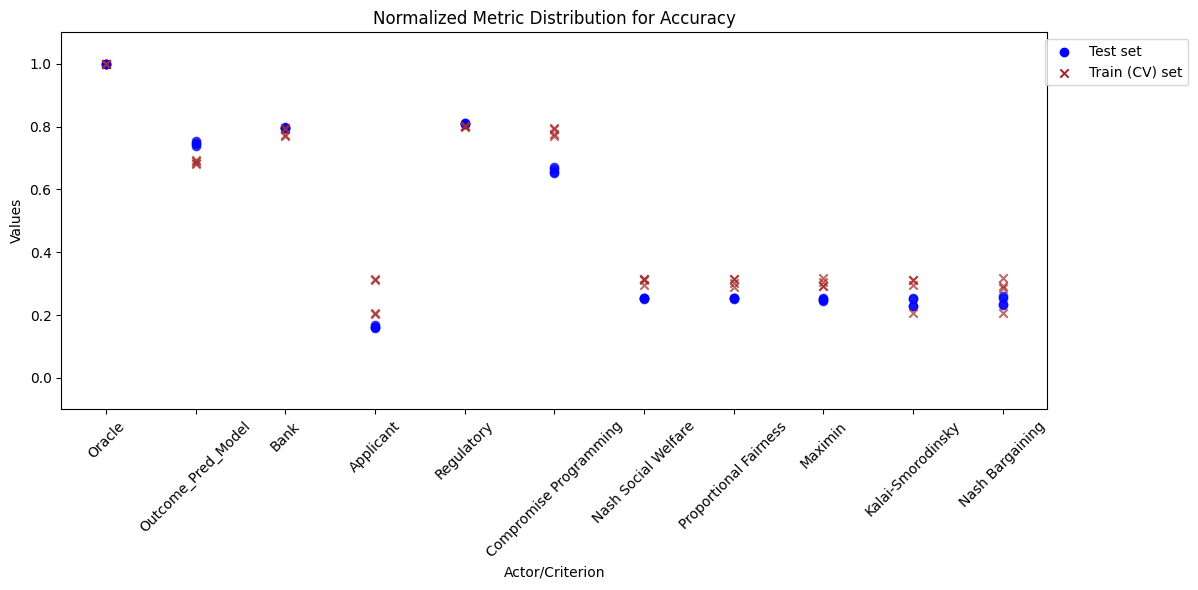

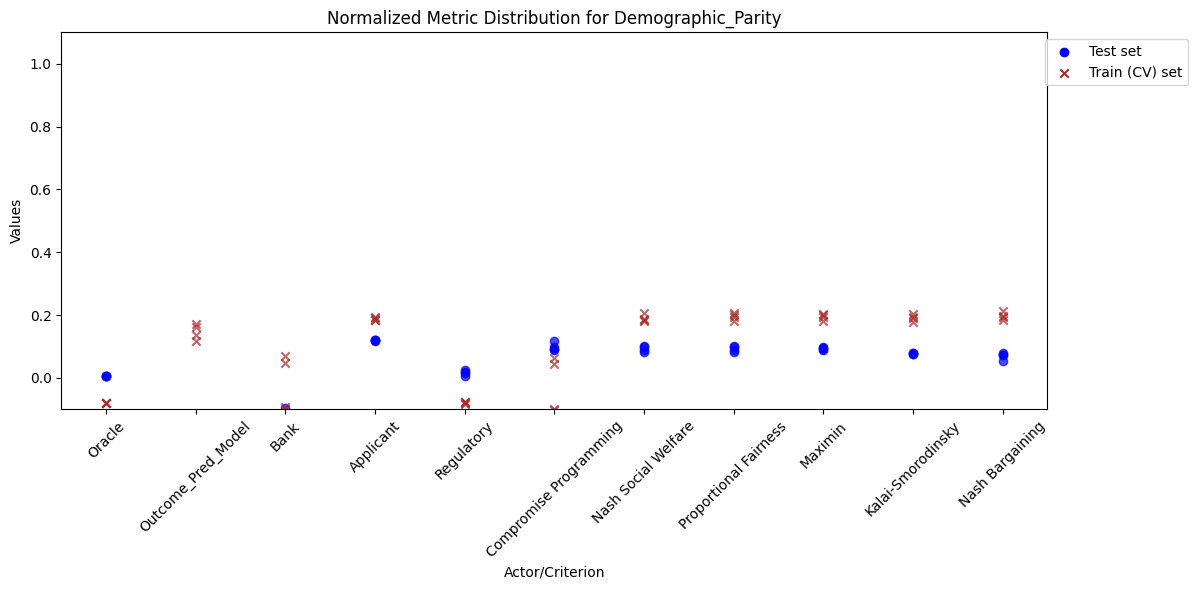

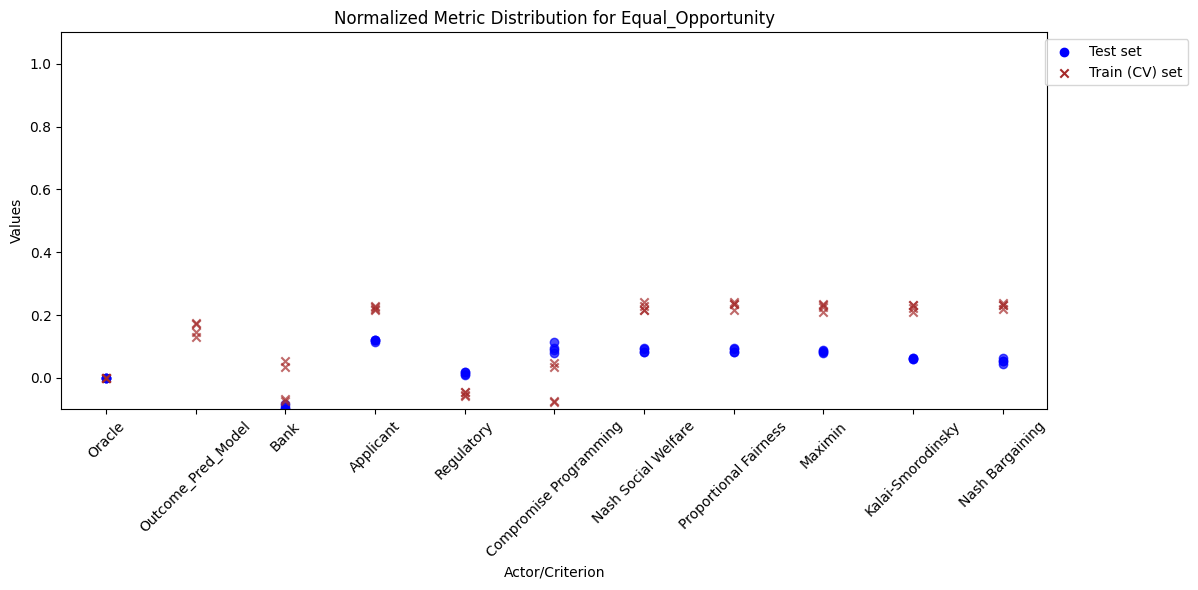

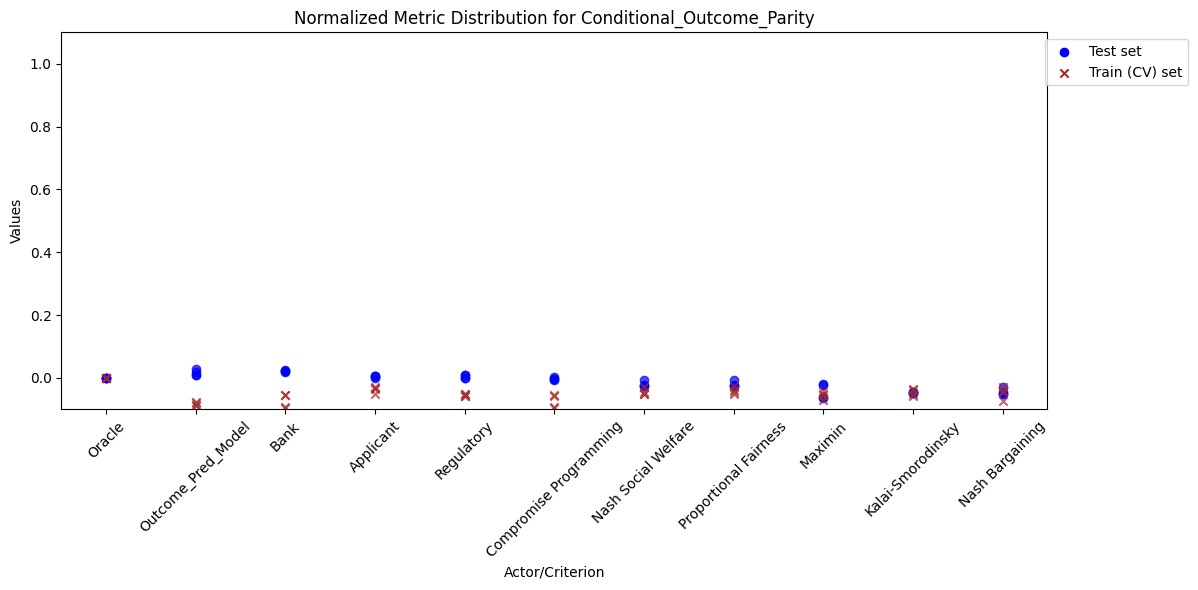

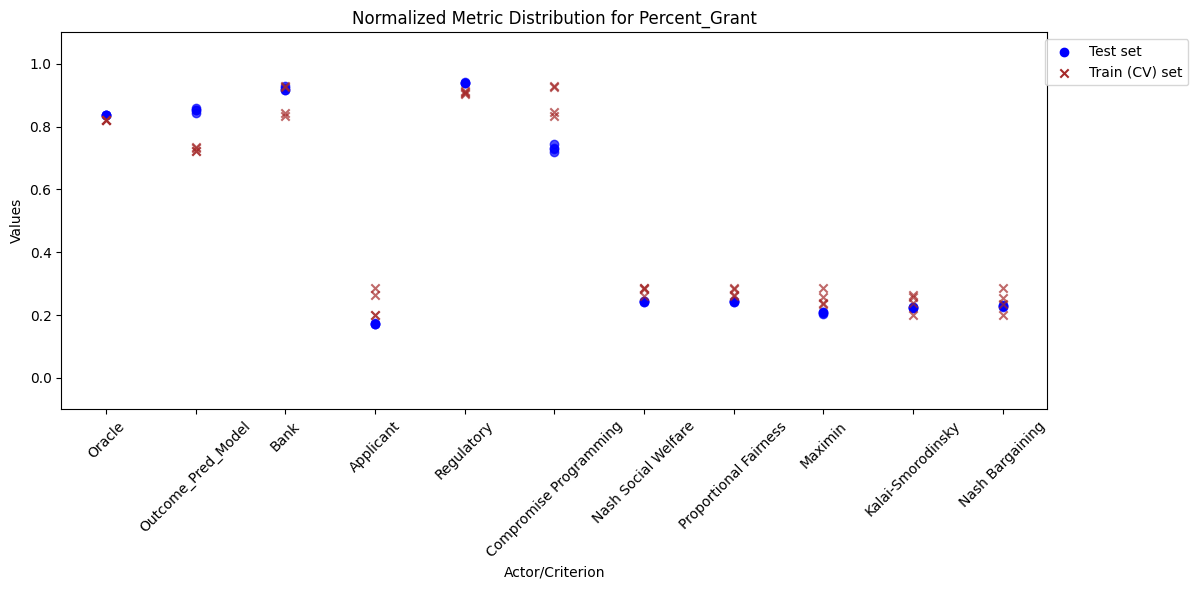

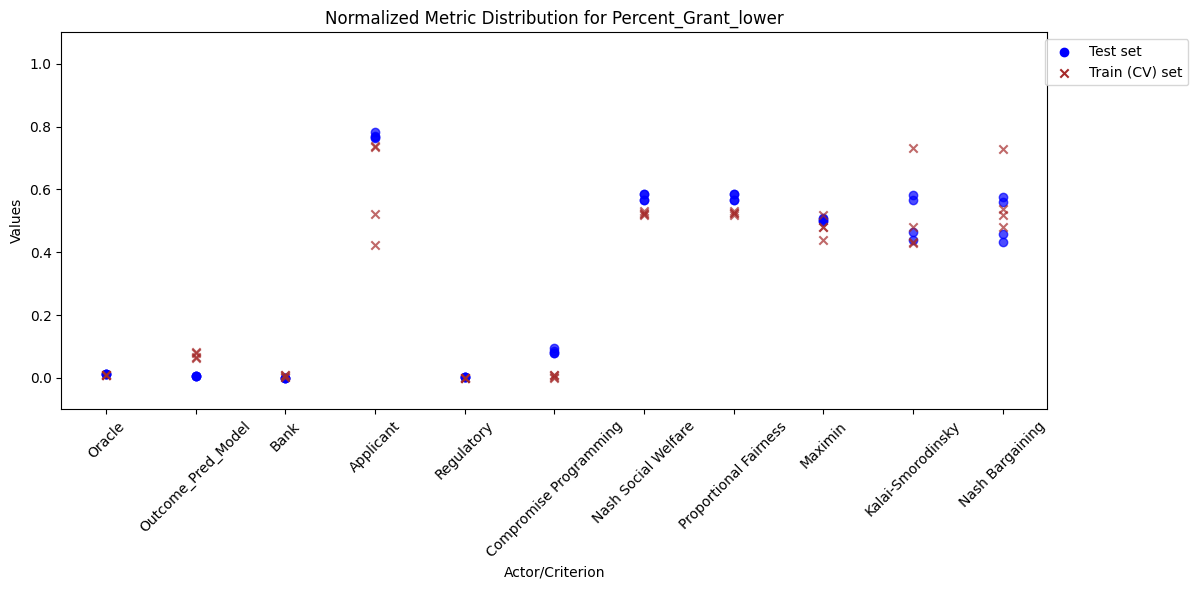

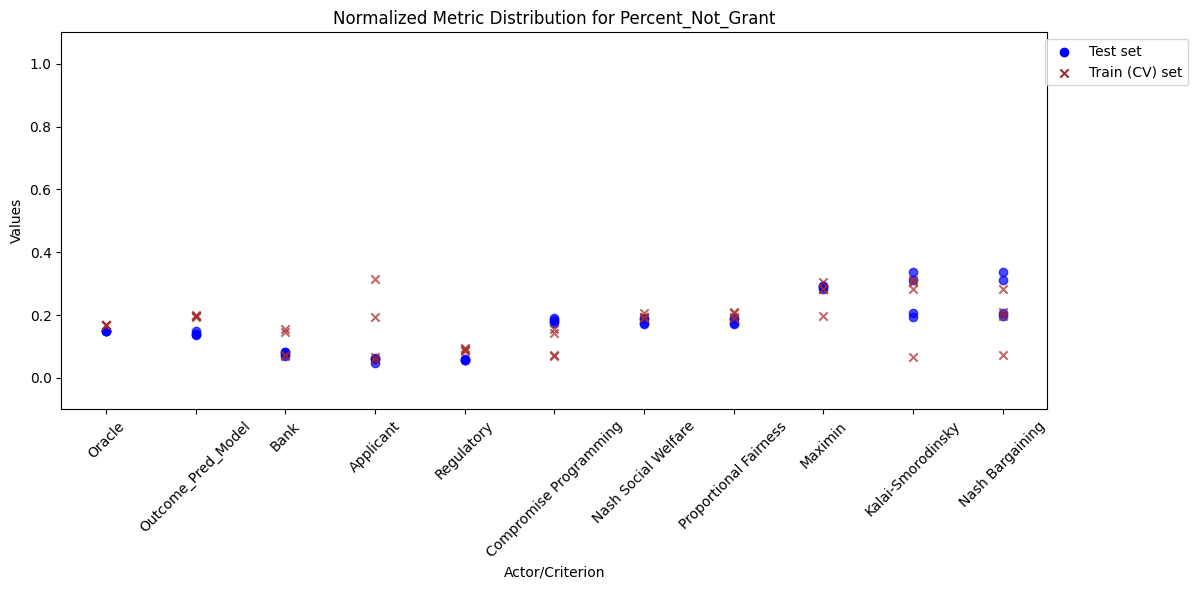

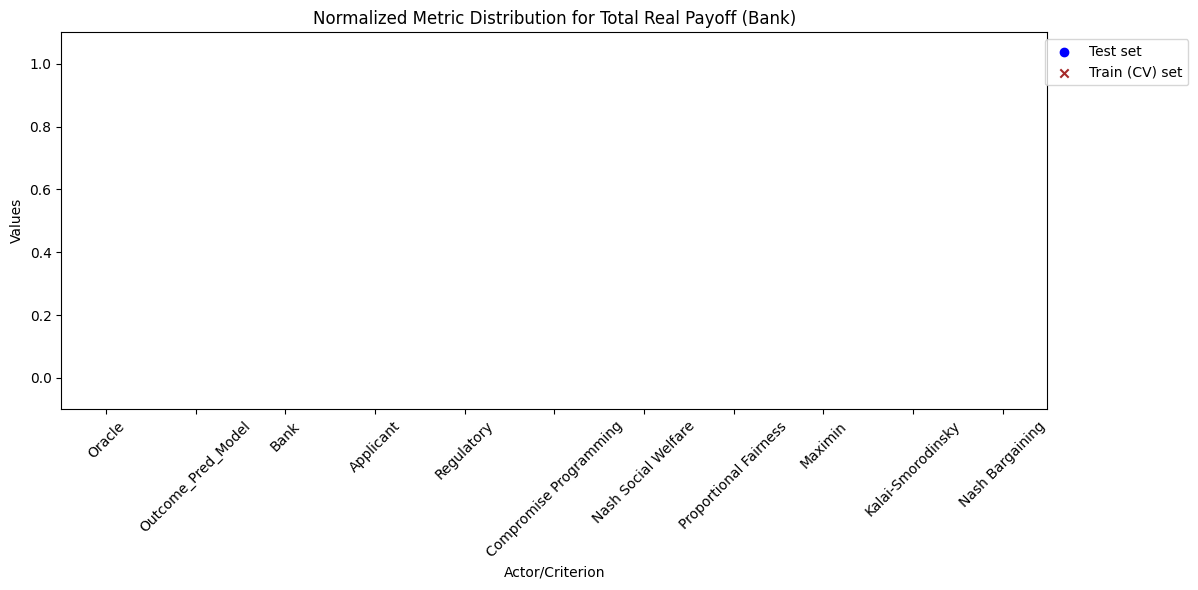

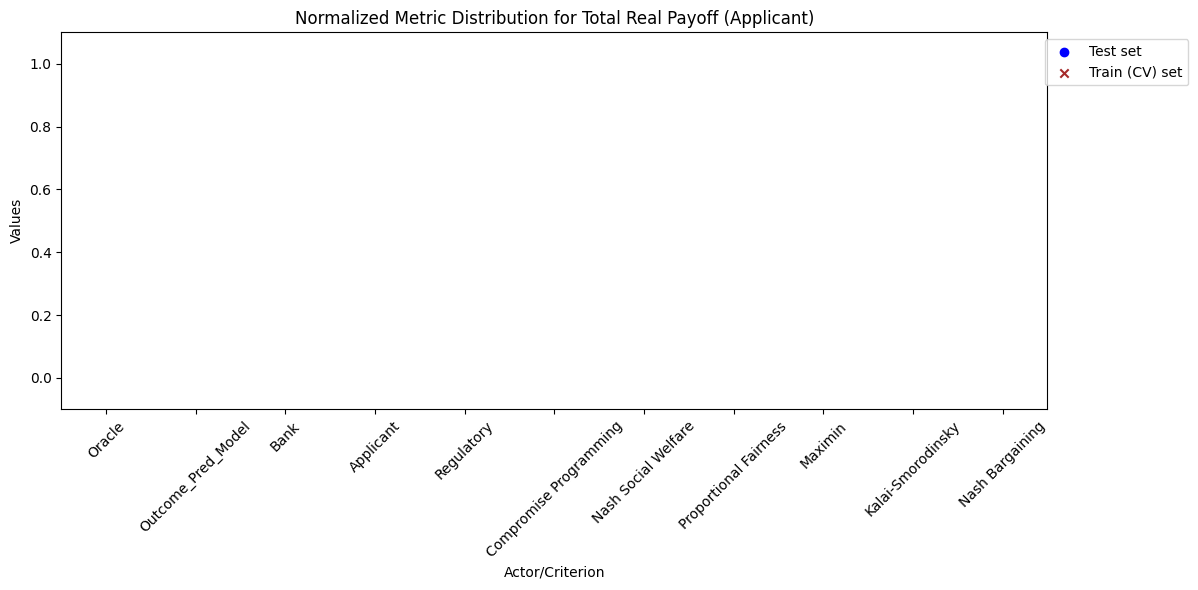

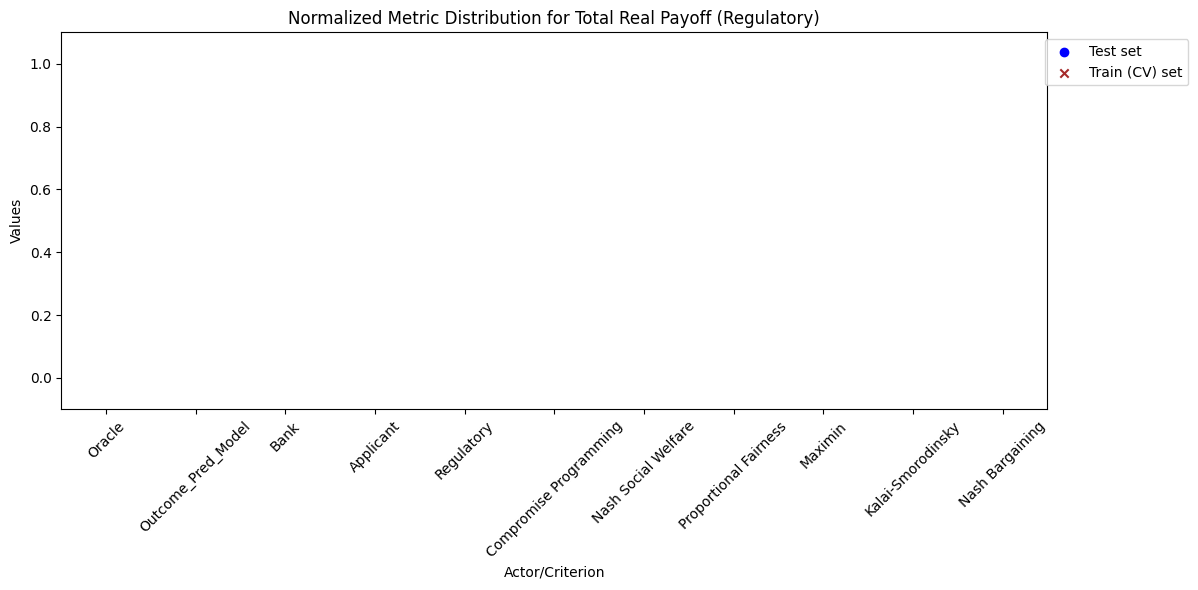

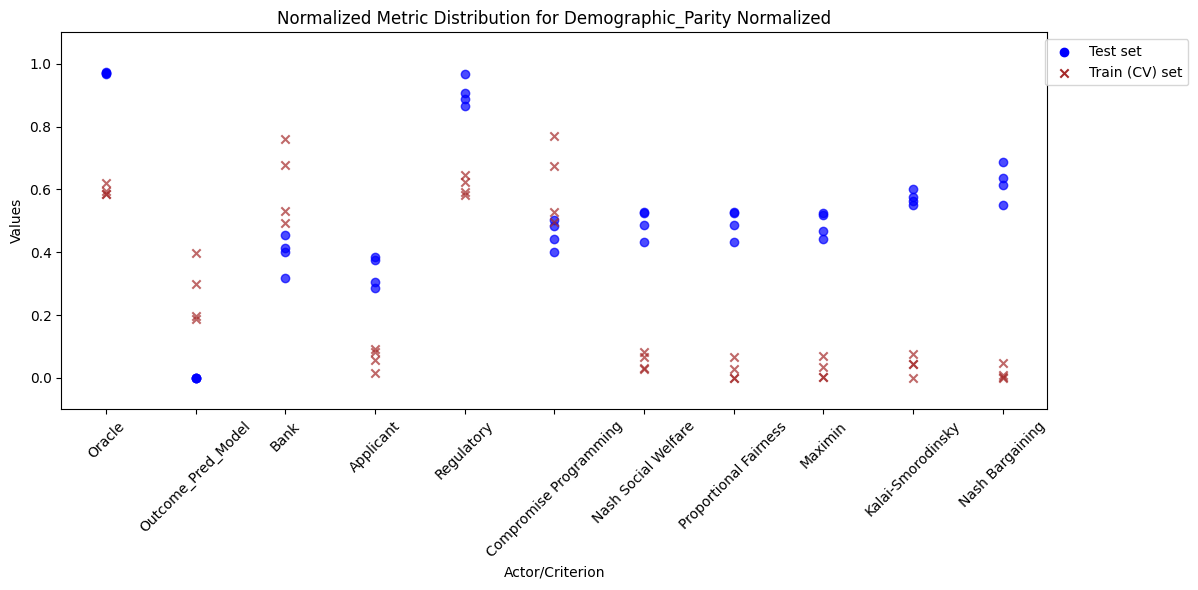

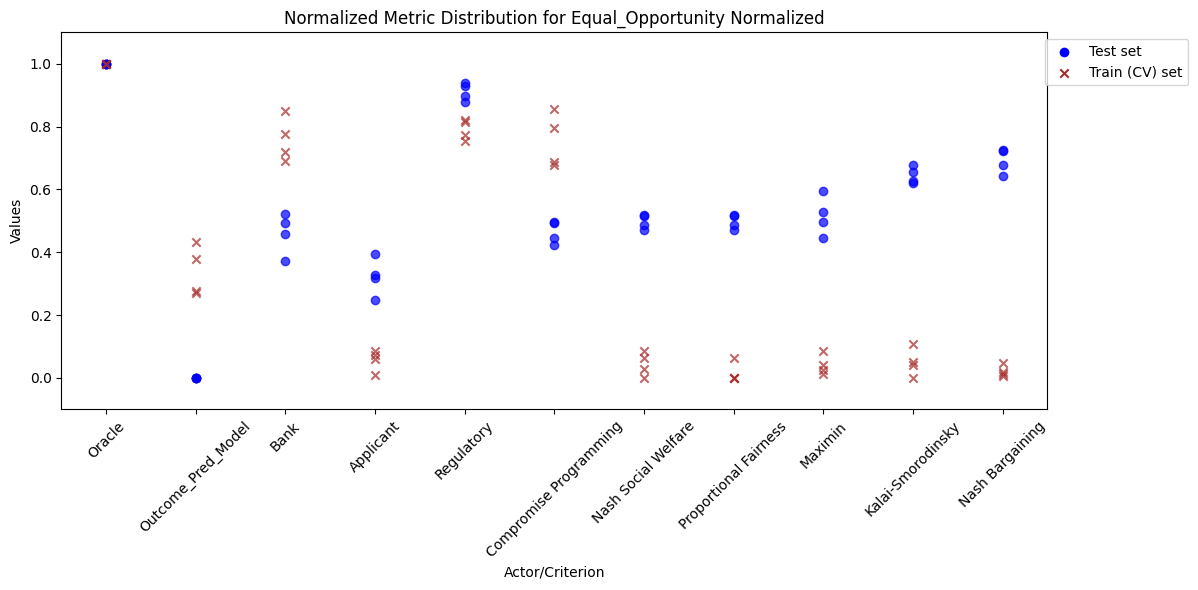

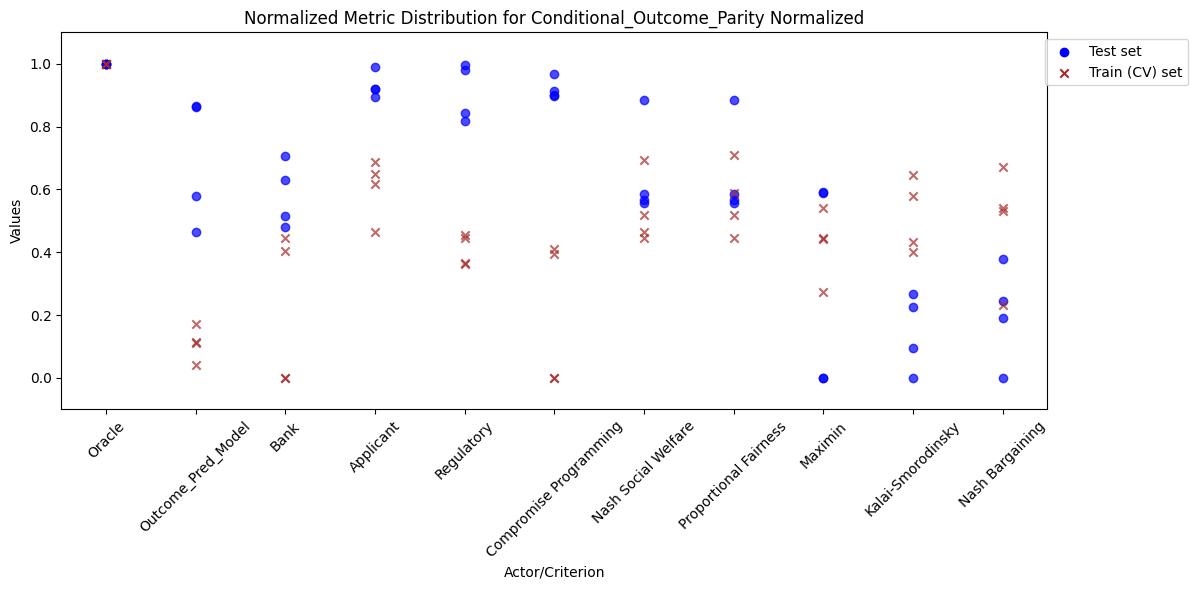

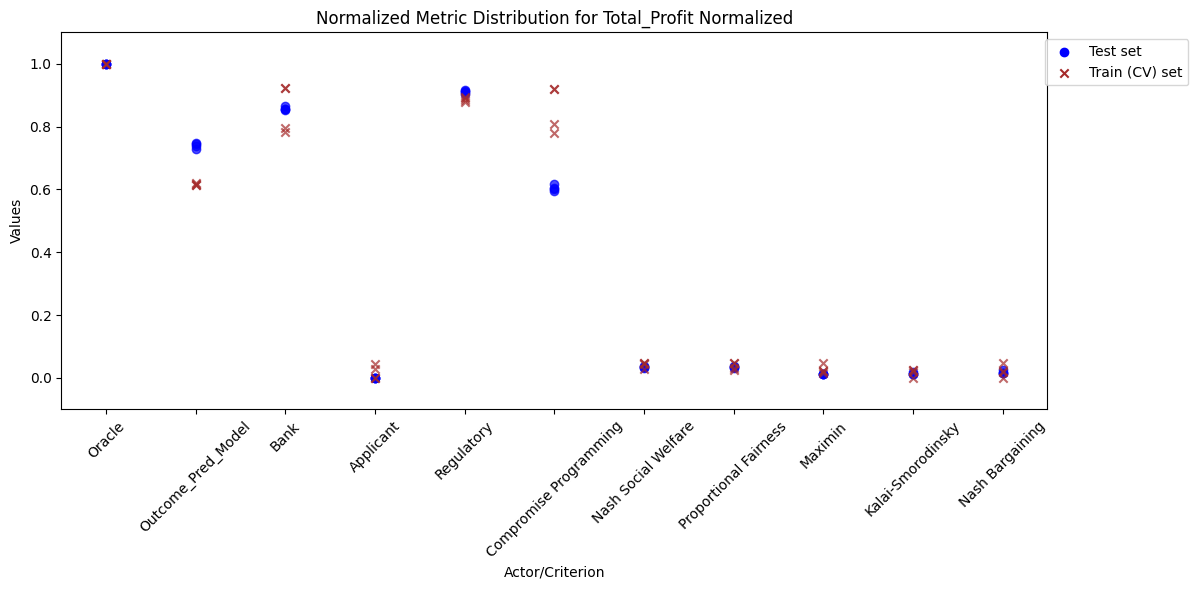

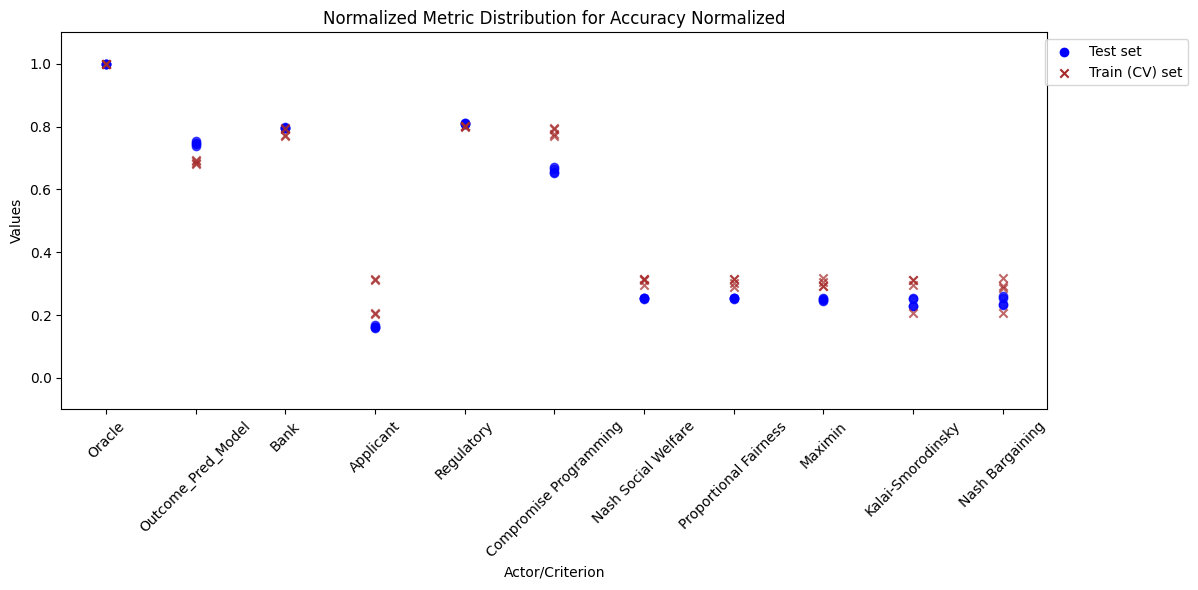

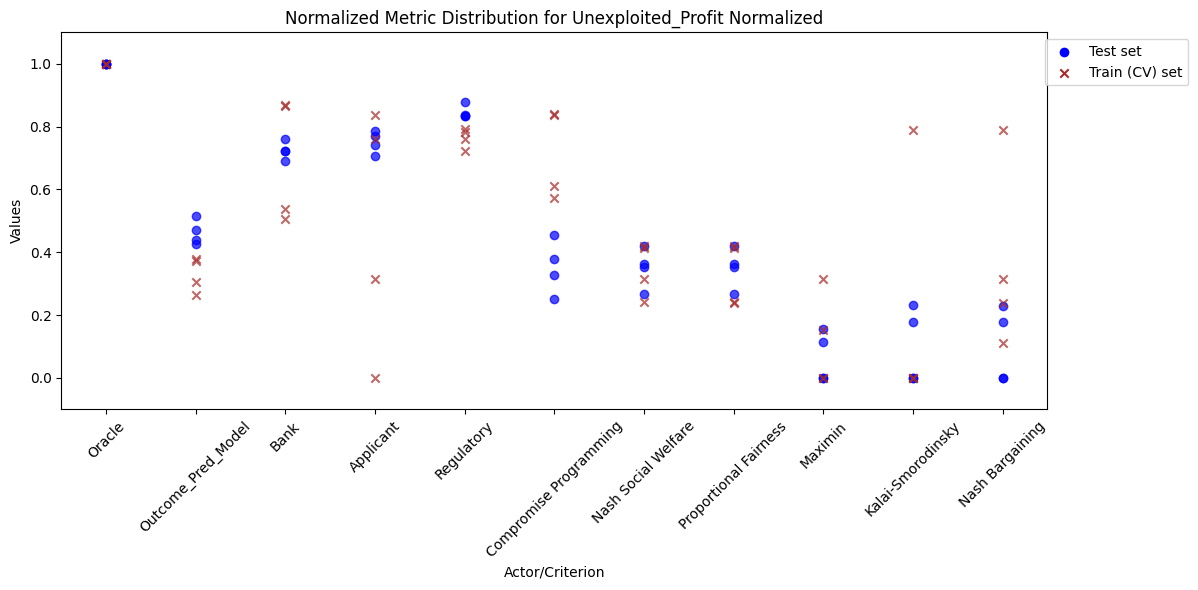

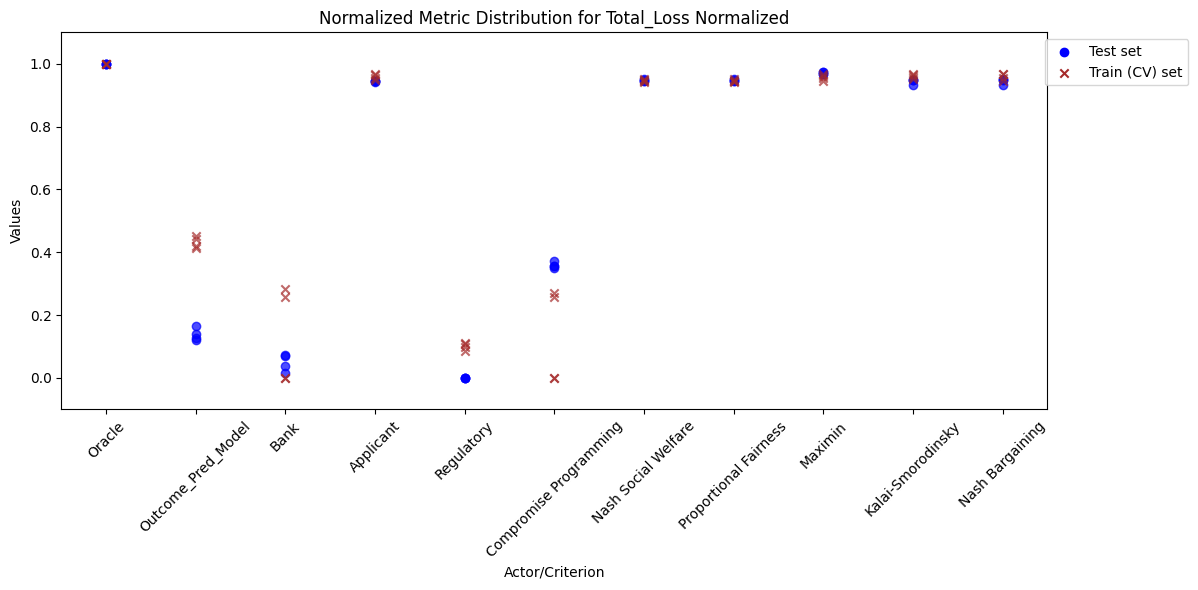

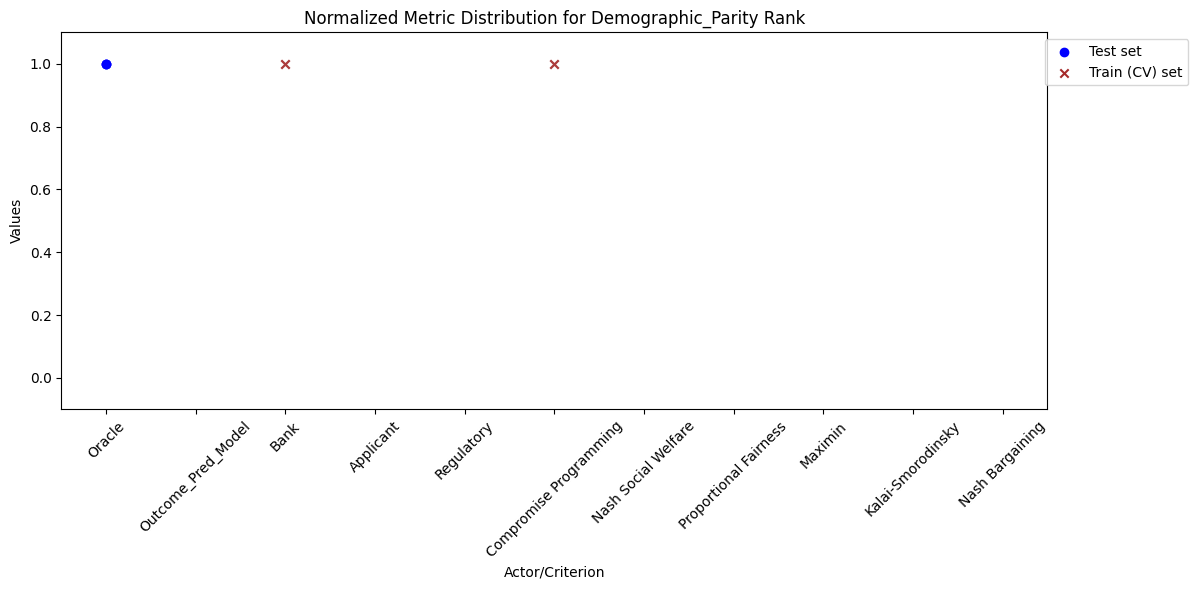

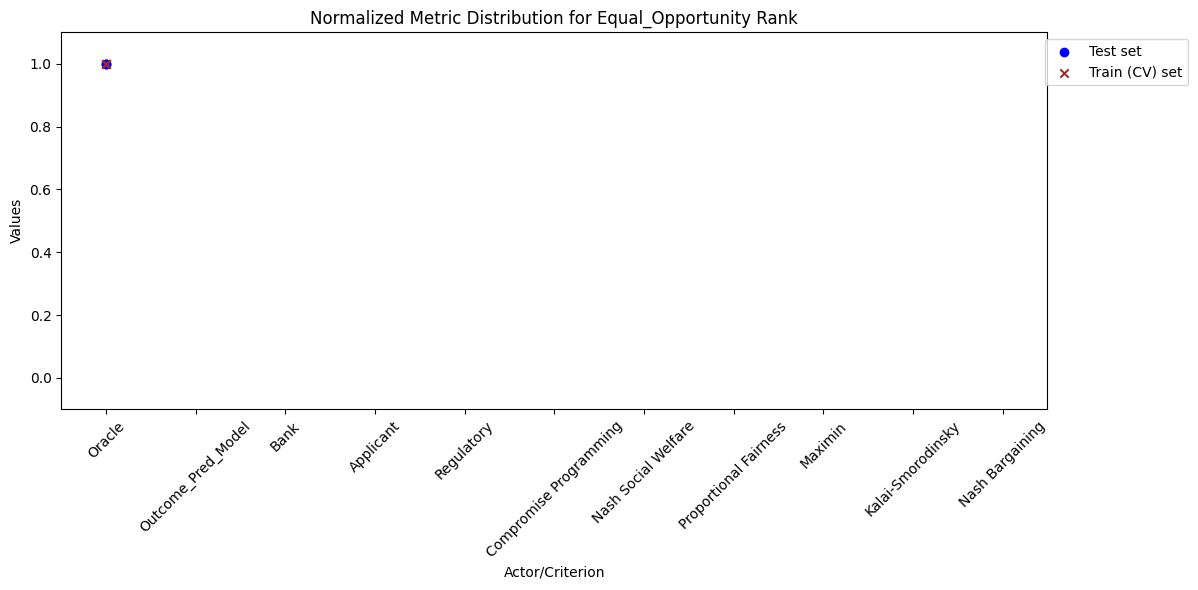

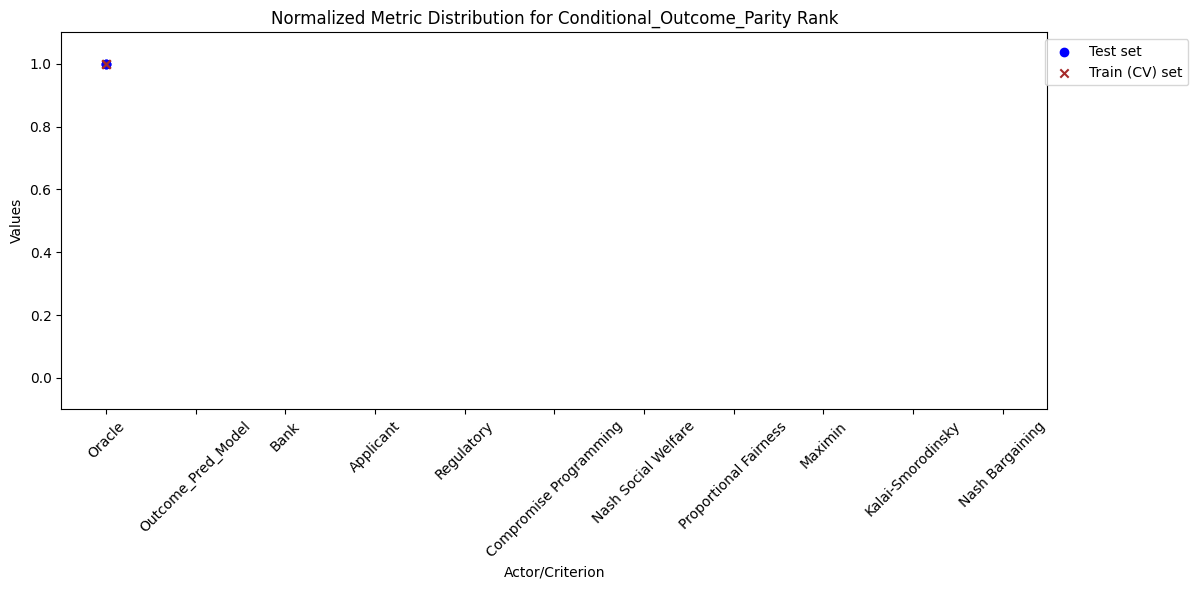

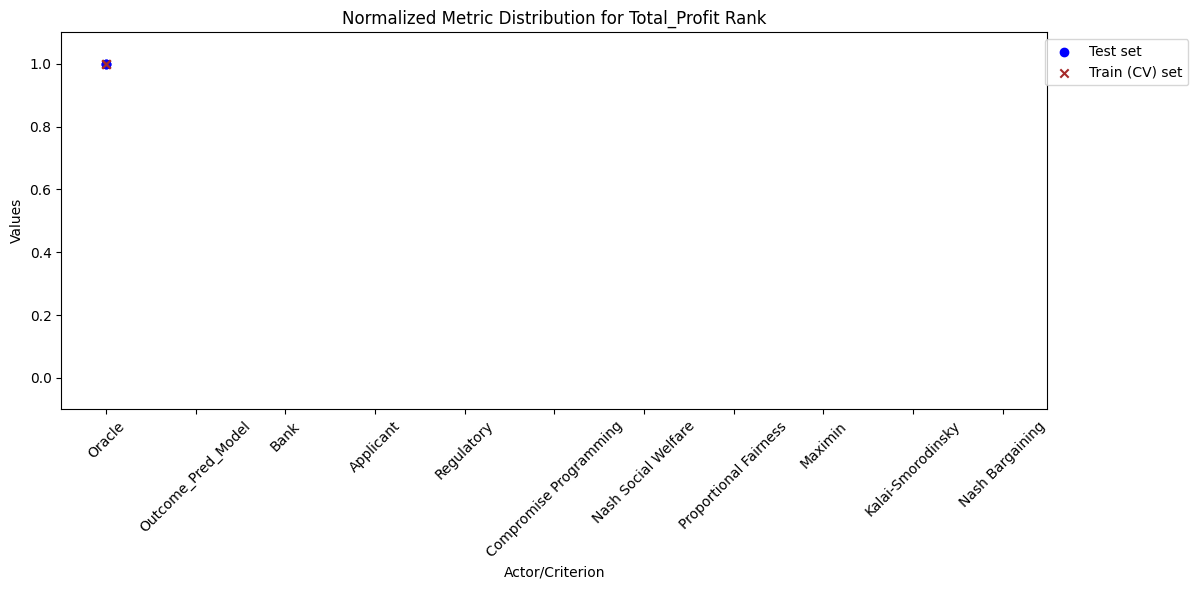

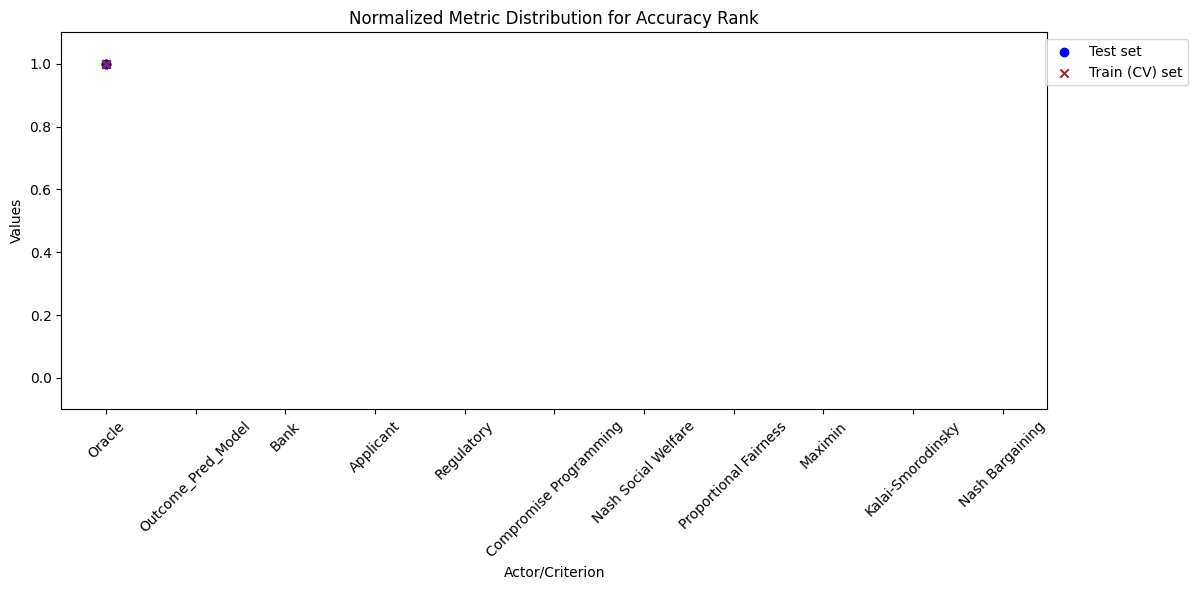

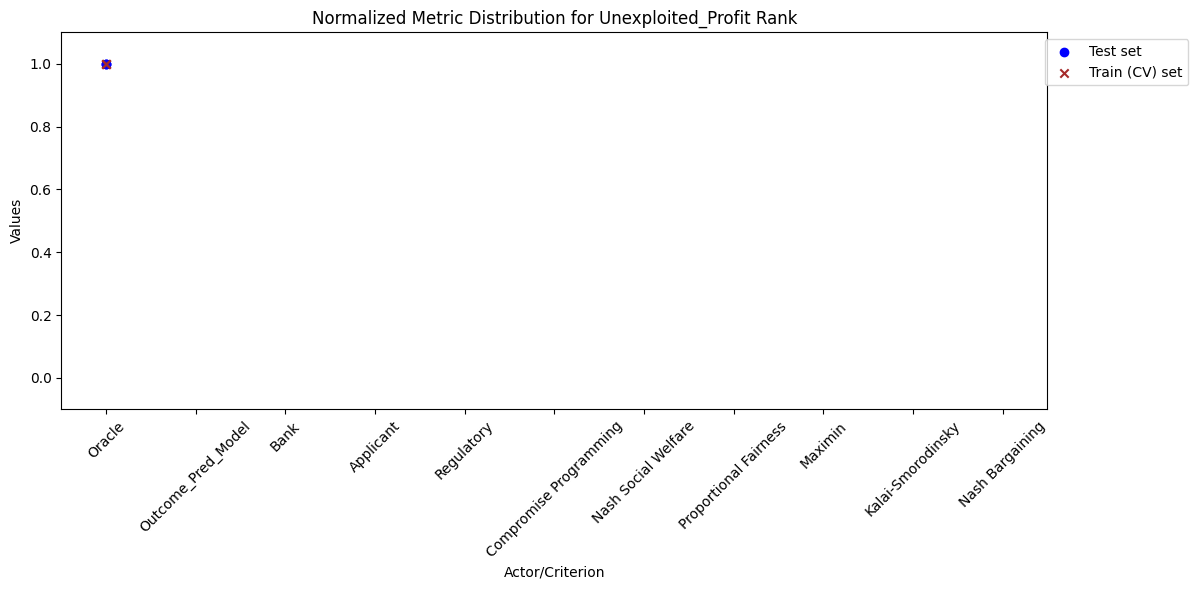

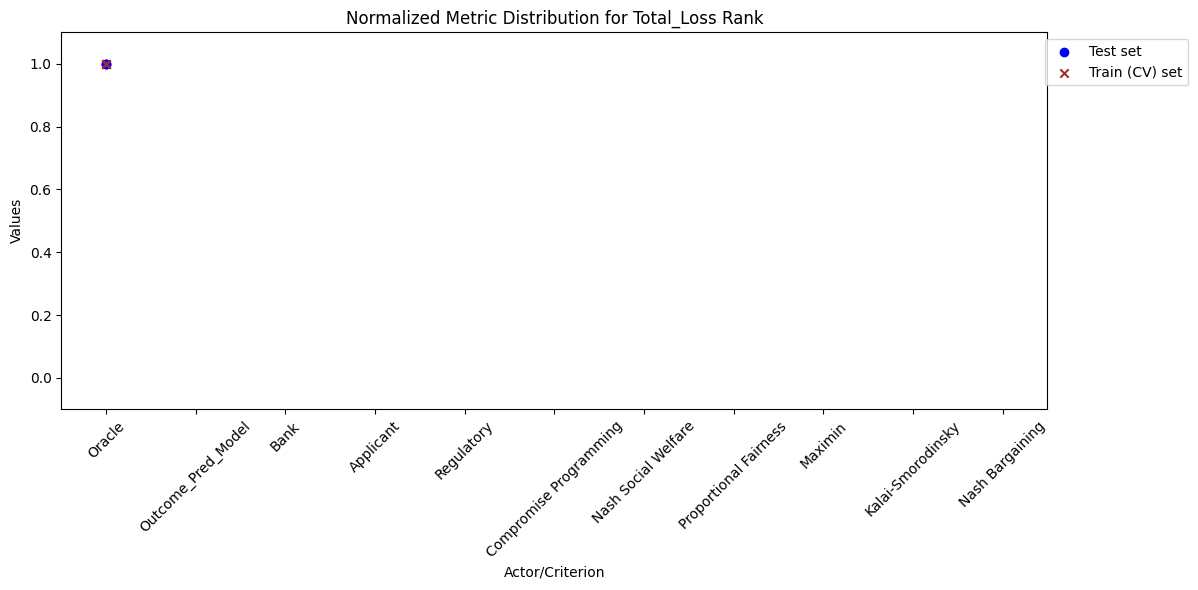

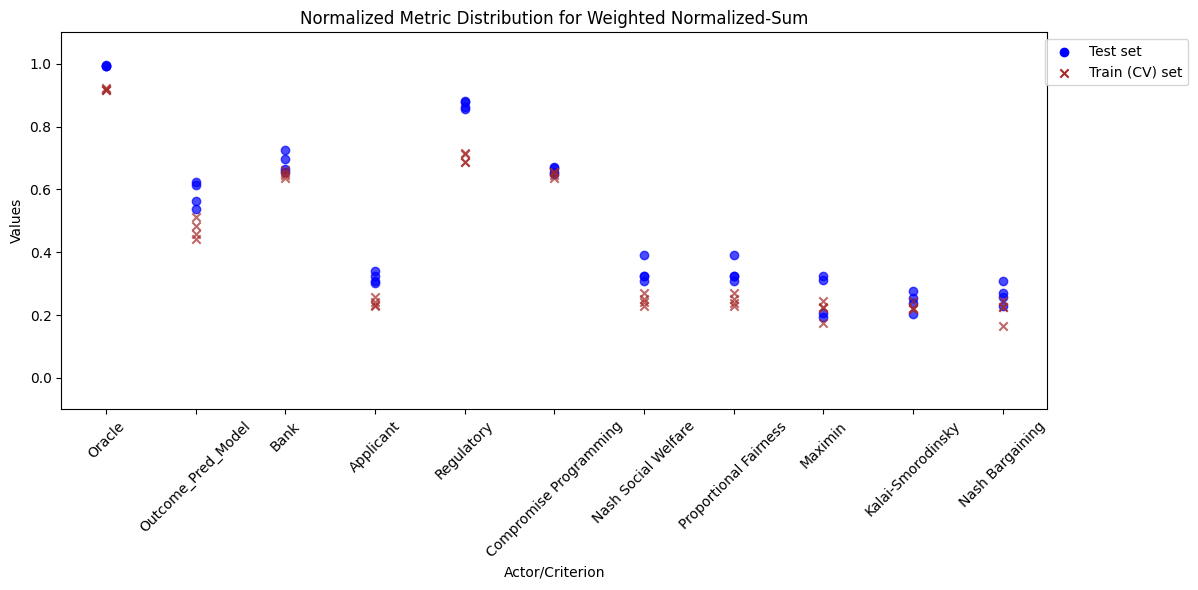

In [ ]:
import matplotlib.pyplot as plt

def visualize_dictionary_scatter_custom_order(data_dict, title_prefix="Comparison"):
    """
    Visualizes the distributions in the dictionary for each outer key (column name)
    and inner key (Actor/criterion) using scatter plots, with a fixed y-axis range (0-1),
    a generalized legend, and a custom x-axis order.
    
    Parameters:
        data_dict: dict
            Nested dictionary with the structure:
            {outer_key: {inner_key: {"results": [values], "results_cv": [values]}}}
        title_prefix: str
            Prefix for the plot titles.
    """
    # Custom X-axis order
    x_order = [
        'Oracle', 'Outcome_Pred_Model', 'Bank', 'Applicant', 'Regulatory', 
        'Compromise Programming', 'Nash Social Welfare', 'Proportional Fairness',
        'Maximin', 'Kalai-Smorodinsky', 'Nash Bargaining'
    ]
    
    for outer_key, inner_dict in data_dict.items():
        plt.figure(figsize=(12, 6))
        
        # Prepare data for scatter plot
        for actor in x_order:
            if actor in inner_dict:
                values = inner_dict[actor]
                # Scatter plot for "results"
                plt.scatter(
                    [actor] * len(values["results"]),  # X-axis: actor repeated for each value
                    values["results"],                # Y-axis: results values
                    alpha=0.7,
                    marker='o',                       # Marker for results
                    color='blue'
                )
                # Scatter plot for "results_cv"
                plt.scatter(
                    [actor] * len(values["results_cv"]),
                    values["results_cv"],
                    alpha=0.7,
                    marker='x',                       # Marker for results_cv
                    color='brown'
                )
        
        # Set consistent y-axis range
        plt.ylim(-0.1, 1.1)

        # Add labels and title
        plt.xlabel("Actor/Criterion")
        plt.ylabel("Values")
        plt.title(f"{title_prefix} for {outer_key}")
        plt.xticks(range(len(x_order)), x_order, rotation=45)
        
        # Add generalized legend
        plt.scatter([], [], color='blue', marker='o', label='Test set')
        plt.scatter([], [], color='brown', marker='x', label='Train (CV) set')
        plt.legend( loc='upper right', bbox_to_anchor=(1.15, 1))
        
        plt.tight_layout()
        plt.show()

# Use the updated function with a fixed y-axis range and custom order
visualize_dictionary_scatter_custom_order(comparison_dict, title_prefix="Normalized Metric Distribution")


In [20]:
results.T

,0,1,2,3,4,5,6,7,8,9,10
Actor/Criterion,Oracle,Regulatory,Compromise Programming,Bank,Outcome_Pred_Model,Applicant,Nash Social Welfare,Proportional Fairness,Maximin,Kalai-Smorodinsky,Nash Bargaining
Total_Profit,7969.019225,7254.11095,5030.72765,6887.005075,6024.601525,526.554775,768.067025,768.067025,612.528125,610.339875,638.519075
Total_Loss,74313.69,1203850.0,807000.0,1159675.0,1068175.0,138149.65,137062.58,137062.58,111072.31,134497.31,134497.31
Unexploited_Profit,0.0,553.878075,2076.056425,920.98395,1760.37,862.75005,2125.90515,2125.90515,2949.4542,3332.77125,3332.77125
Precision,1.0,0.368688,0.354932,0.354909,0.339716,0.352997,0.352639,0.352639,0.36827,0.348418,0.349776
Recall,1.0,0.350646,0.334014,0.348139,0.341848,0.32518,0.342441,0.342441,0.350375,0.352617,0.354859
F1 Score,1.0,0.347287,0.342424,0.345269,0.340722,0.145332,0.201918,0.201918,0.216255,0.212943,0.215935
Accuracy,1.0,0.81203,0.665414,0.796992,0.746241,0.167293,0.25,0.25,0.24812,0.253759,0.259398
Demographic_Parity,0.005328,0.017383,0.093291,-0.112421,-0.187806,0.117575,0.0884,0.0884,0.089099,0.07949,0.072414
Equal_Opportunity,0.0,0.020554,0.094598,-0.092153,-0.1705,0.11444,0.082062,0.082062,0.085714,0.063458,0.055007
